In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

csv_file = "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/res/annotation.csv"
df = pd.read_csv(csv_file)
df.head()

,Unnamed: 0,ID,r_cheek_pigmentation,r_cheek_pigmentation_4,r_cheek_pigmentation_3
0,0,1,3,2,1
1,1,2,3,2,1
2,2,3,0,0,0
3,3,4,3,2,1
4,4,6,3,2,1


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import ResNet50_Weights

# 데이터셋 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, csv_file=None, image_folder=None, image_paths=None, labels=None, transform=None):
        if csv_file is not None and image_folder is not None:
            # CSV 파일 로드 및 레이블 설정
            self.image_paths = []
            self.labels = []
            self.transform = transform

            df = pd.read_csv(csv_file)

            for image_file in os.listdir(image_folder):
                if image_file.endswith('.jpg'):
                    image_path = os.path.join(image_folder, image_file)
                    image_id = image_file.split('_')[0]
                    label_data = df[df['ID'] == int(image_id)]['r_cheek_pigmentation_3'].values
                    if len(label_data) > 0:
                        label = label_data[0]
                        self.image_paths.append(image_path)
                        self.labels.append(label)

            # 넘파이 배열로 변경
            self.image_paths = np.array(self.image_paths)
            self.labels = np.array(self.labels)
        elif image_paths is not None and labels is not None:
            self.image_paths = np.array(image_paths)
            self.labels = np.array(labels)
            self.transform = transform
        else:
            raise ValueError("Either (csv_file and image_folder) or (image_paths and labels) must be provided")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터셋 준비
csv_file = "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/res/annotation.csv"
image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_r_images_train'

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50의 입력 크기에 맞게 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 전체 데이터셋 생성
full_dataset = SkinDataset(csv_file=csv_file, image_folder=image_folder, transform=transform)

# 데이터 분할
image_paths = full_dataset.image_paths
labels = full_dataset.labels
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.1, random_state=3)

# 데이터셋 생성
train_dataset = SkinDataset(image_paths=train_image_paths, labels=train_labels, transform=transform)
val_dataset = SkinDataset(image_paths=val_image_paths, labels=val_labels, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=3)

# 모델 정의
class ResNetforClassification(nn.Module):
    def __init__(self, num_classes):
        super(ResNetforClassification, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.dropout = nn.Dropout(p=0.5)  # 50% 드롭아웃
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            self.dropout,
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# `device` 변수를 여기에 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([2.0, 1.0, 2.5], dtype=torch.float32).to(device)

num_classes = 3  # 색소침착 등급이 3개
model = ResNetforClassification(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-8)


# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 모델 학습 및 검증
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model, model_save_path)
            print(f"Best model saved to {model_save_path}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/model/model_v6/resnet50_0.0001_3_3_pigmentation_classification_model_v1.pth'

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=80, patience=10)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


Epoch [1/80], Train Loss: 1.0505, Train Accuracy: 0.5727, Val Loss: 1.0011, Val Accuracy: 0.5116
Best model saved to /content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/model/model_v6/resnet50_0.0001_3_3_pigmentation_classification_model_v1.pth
Epoch [2/80], Train Loss: 0.8416, Train Accuracy: 0.6506, Val Loss: 0.7587, Val Accuracy: 0.6628
Best model saved to /content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/model/model_v6/resnet50_0.0001_3_3_pigmentation_classification_model_v1.pth
Epoch [3/80], Train Loss: 0.5738, Train Accuracy: 0.7974, Val Loss: 0.6978, Val Accuracy: 0.5698
Epoch [4/80], Train Loss: 0.3040, Train Accuracy: 0.8948, Val Loss: 0.9391, Val Accuracy: 0.6163
EarlyStopping counter: 1 out of 10
Epoch [5/80], Train Loss: 0.1268, Train Accuracy: 0.9636, Val Loss: 0.9836, Val Accuracy: 0.5930
EarlyStopping counter: 2 out of 10
Epoch [6/80], Train Loss: 0.0574, Train Accuracy: 0.9844, Val Loss: 1.2679, V

Accuracy: 0.6792
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.73        31
           1       0.66      0.82      0.73        57
           2       0.50      0.17      0.25        18

    accuracy                           0.68       106
   macro avg       0.64      0.57      0.57       106
weighted avg       0.66      0.68      0.65       106



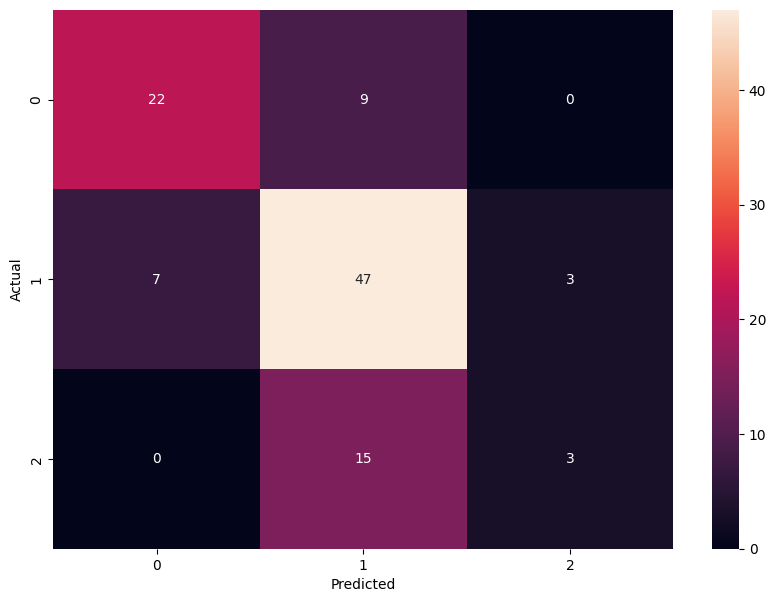

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 평가를 위한 설정
model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/model/model_v6/resnet50_0.0001_3_3_pigmentation_classification_model_v1.pth'

val_dataset = SkinDataset(csv_file="/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/res/annotation.csv",
                          image_folder='/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_r_images_val',
                          transform=transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 모델 로드 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_save_path)
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # val_loader로 변경
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 그리기
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

가중치 높이기

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import ResNet50_Weights

# 데이터셋 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, csv_file=None, image_folder=None, image_paths=None, labels=None, transform=None):
        if csv_file is not None and image_folder is not None:
            # CSV 파일 로드 및 레이블 설정
            self.image_paths = []
            self.labels = []
            self.transform = transform

            df = pd.read_csv(csv_file)

            for image_file in os.listdir(image_folder):
                if image_file.endswith('.jpg'):
                    image_path = os.path.join(image_folder, image_file)
                    image_id = image_file.split('_')[0]
                    label_data = df[df['ID'] == int(image_id)]['r_cheek_pigmentation_3'].values
                    if len(label_data) > 0:
                        label = label_data[0]
                        self.image_paths.append(image_path)
                        self.labels.append(label)

            # 넘파이 배열로 변경
            self.image_paths = np.array(self.image_paths)
            self.labels = np.array(self.labels)
        elif image_paths is not None and labels is not None:
            self.image_paths = np.array(image_paths)
            self.labels = np.array(labels)
            self.transform = transform
        else:
            raise ValueError("Either (csv_file and image_folder) or (image_paths and labels) must be provided")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# 데이터셋 준비
csv_file = "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/res/annotation.csv"
image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_r_images_train'

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50의 입력 크기에 맞게 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 전체 데이터셋 생성
full_dataset = SkinDataset(csv_file=csv_file, image_folder=image_folder, transform=transform)

# 데이터 분할
image_paths = full_dataset.image_paths
labels = full_dataset.labels
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.1, random_state=3)

# 데이터셋 생성
train_dataset = SkinDataset(image_paths=train_image_paths, labels=train_labels, transform=transform)
val_dataset = SkinDataset(image_paths=val_image_paths, labels=val_labels, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=3)

# 모델 정의
class ResNetforClassification(nn.Module):
    def __init__(self, num_classes):
        super(ResNetforClassification, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.dropout = nn.Dropout(p=0.5)  # 50% 드롭아웃
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            self.dropout,
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# `device` 변수를 여기에 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([2.0, 1.0, 2.0], dtype=torch.float32).to(device)

num_classes = 3  # 색소침착 등급이 3개
model = ResNetforClassification(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-8)


# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 모델 학습 및 검증
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model, model_save_path)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/model/model_v6/resnet50_0.0001_3_3_pigmentation_classification_model_v2.pth'

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5)

Epoch [1/50], Train Loss: 1.0297, Train Accuracy: 0.5286, Val Loss: 0.9649, Val Accuracy: 0.4884
Epoch [2/50], Train Loss: 0.7781, Train Accuracy: 0.6740, Val Loss: 0.7907, Val Accuracy: 0.6279
Epoch [3/50], Train Loss: 0.5171, Train Accuracy: 0.7753, Val Loss: 0.7348, Val Accuracy: 0.6512
Epoch [4/50], Train Loss: 0.3035, Train Accuracy: 0.9182, Val Loss: 0.8371, Val Accuracy: 0.7093
EarlyStopping counter: 1 out of 5
Epoch [5/50], Train Loss: 0.1873, Train Accuracy: 0.9532, Val Loss: 1.0775, Val Accuracy: 0.6279
EarlyStopping counter: 2 out of 5
Epoch [6/50], Train Loss: 0.0957, Train Accuracy: 0.9831, Val Loss: 1.0686, Val Accuracy: 0.6860
EarlyStopping counter: 3 out of 5
Epoch [7/50], Train Loss: 0.0794, Train Accuracy: 0.9818, Val Loss: 1.0240, Val Accuracy: 0.6163
EarlyStopping counter: 4 out of 5
Epoch [8/50], Train Loss: 0.0642, Train Accuracy: 0.9753, Val Loss: 1.0878, Val Accuracy: 0.6860
EarlyStopping counter: 5 out of 5
Early stopping


Accuracy: 0.7075
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83        31
           1       0.70      0.79      0.74        57
           2       0.40      0.22      0.29        18

    accuracy                           0.71       106
   macro avg       0.64      0.62      0.62       106
weighted avg       0.68      0.71      0.69       106



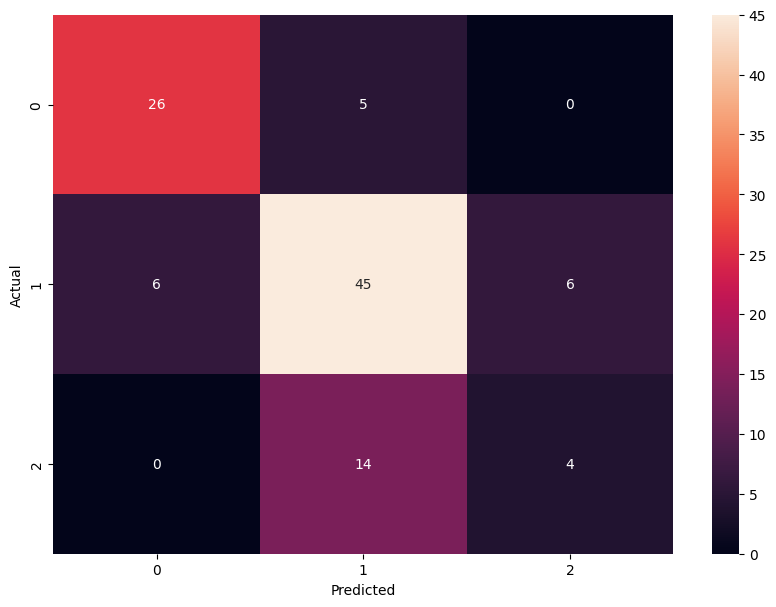

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 평가를 위한 설정
model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/model/model_v6/resnet50_0.0001_3_3_pigmentation_classification_model_v2.pth'

val_dataset = SkinDataset(csv_file="/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/res/annotation.csv",
                          image_folder='/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_r_images_val',
                          transform=transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 모델 로드 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_save_path)
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # val_loader로 변경
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 그리기
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

YCbCr

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import ResNet50_Weights

# 데이터셋 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, csv_file=None, image_folder=None, image_paths=None, labels=None, transform=None):
        if csv_file is not None and image_folder is not None:
            # CSV 파일 로드 및 레이블 설정
            self.image_paths = []
            self.labels = []
            self.transform = transform

            df = pd.read_csv(csv_file)

            for image_file in os.listdir(image_folder):
                if image_file.endswith('.jpg'):
                    image_path = os.path.join(image_folder, image_file)
                    image_id = image_file.split('_')[0]
                    label_data = df[df['ID'] == int(image_id)]['r_cheek_pigmentation_3'].values
                    if len(label_data) > 0:
                        label = label_data[0]
                        self.image_paths.append(image_path)
                        self.labels.append(label)

            # 넘파이 배열로 변경
            self.image_paths = np.array(self.image_paths)
            self.labels = np.array(self.labels)
        elif image_paths is not None and labels is not None:
            self.image_paths = np.array(image_paths)
            self.labels = np.array(labels)
            self.transform = transform
        else:
            raise ValueError("Either (csv_file and image_folder) or (image_paths and labels) must be provided")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('YCbCr')  # YCbCr 색상 공간으로 변환
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# 데이터셋 준비
csv_file = "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/res/annotation.csv"
image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_r_images_train'

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50의 입력 크기에 맞게 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 전체 데이터셋 생성
full_dataset = SkinDataset(csv_file=csv_file, image_folder=image_folder, transform=transform)

# 데이터 분할
image_paths = full_dataset.image_paths
labels = full_dataset.labels
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.1, random_state=3)

# 데이터셋 생성
train_dataset = SkinDataset(image_paths=train_image_paths, labels=train_labels, transform=transform)
val_dataset = SkinDataset(image_paths=val_image_paths, labels=val_labels, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=3)

# 모델 정의
class ResNetforClassification(nn.Module):
    def __init__(self, num_classes):
        super(ResNetforClassification, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.dropout = nn.Dropout(p=0.5)  # 50% 드롭아웃
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            self.dropout,
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# `device` 변수를 여기에 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([2.0, 1.0, 2.5], dtype=torch.float32).to(device)

num_classes = 3  # 색소침착 등급이 3개
model = ResNetforClassification(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-4)


# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 모델 학습 및 검증
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model, model_save_path)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/model/model_v6/YCbCr_resnet50_0.0001_3_3_pigmentation_classification_model_v1.pth'

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10)

Epoch [1/50], Train Loss: 1.0193, Train Accuracy: 0.5338, Val Loss: 1.0529, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.8224, Train Accuracy: 0.6558, Val Loss: 0.8077, Val Accuracy: 0.6163
Epoch [3/50], Train Loss: 0.6017, Train Accuracy: 0.7481, Val Loss: 0.7583, Val Accuracy: 0.6860
Epoch [4/50], Train Loss: 0.3962, Train Accuracy: 0.8935, Val Loss: 0.7804, Val Accuracy: 0.6977
EarlyStopping counter: 1 out of 5
Epoch [5/50], Train Loss: 0.2804, Train Accuracy: 0.9078, Val Loss: 1.1416, Val Accuracy: 0.5116
EarlyStopping counter: 2 out of 5
Epoch [6/50], Train Loss: 0.1834, Train Accuracy: 0.9571, Val Loss: 1.1454, Val Accuracy: 0.5930
EarlyStopping counter: 3 out of 5
Epoch [7/50], Train Loss: 0.1274, Train Accuracy: 0.9610, Val Loss: 1.0020, Val Accuracy: 0.7093
EarlyStopping counter: 4 out of 5
Epoch [8/50], Train Loss: 0.0738, Train Accuracy: 0.9909, Val Loss: 1.0073, Val Accuracy: 0.6628
EarlyStopping counter: 5 out of 5
Early stopping


Accuracy: 0.6887
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.84      0.72        31
           1       0.73      0.70      0.71        57
           2       0.70      0.39      0.50        18

    accuracy                           0.69       106
   macro avg       0.69      0.64      0.65       106
weighted avg       0.70      0.69      0.68       106



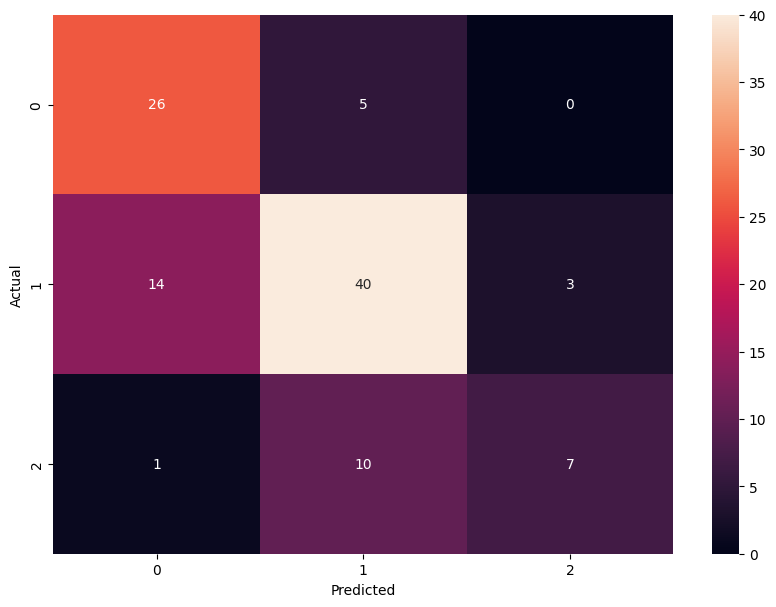

In [19]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 평가를 위한 설정
model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/model/model_v6/YCbCr_resnet50_0.0001_3_3_pigmentation_classification_model_v1.pth'

val_dataset = SkinDataset(csv_file="/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/res/annotation.csv",
                          image_folder='/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_r_images_val',
                          transform=transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 모델 로드 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_save_path)
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # val_loader로 변경
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 그리기
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

lr 조절

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import ResNet50_Weights

# 데이터셋 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, csv_file=None, image_folder=None, image_paths=None, labels=None, transform=None):
        if csv_file is not None and image_folder is not None:
            # CSV 파일 로드 및 레이블 설정
            self.image_paths = []
            self.labels = []
            self.transform = transform

            df = pd.read_csv(csv_file)

            for image_file in os.listdir(image_folder):
                if image_file.endswith('.jpg'):
                    image_path = os.path.join(image_folder, image_file)
                    image_id = image_file.split('_')[0]
                    label_data = df[df['ID'] == int(image_id)]['r_cheek_pigmentation_3'].values
                    if len(label_data) > 0:
                        label = label_data[0]
                        self.image_paths.append(image_path)
                        self.labels.append(label)

            # 넘파이 배열로 변경
            self.image_paths = np.array(self.image_paths)
            self.labels = np.array(self.labels)
        elif image_paths is not None and labels is not None:
            self.image_paths = np.array(image_paths)
            self.labels = np.array(labels)
            self.transform = transform
        else:
            raise ValueError("Either (csv_file and image_folder) or (image_paths and labels) must be provided")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('YCbCr')  # YCbCr 색상 공간으로 변환
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# 데이터셋 준비
csv_file = "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/res/annotation.csv"
image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_r_images_train'

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50의 입력 크기에 맞게 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 전체 데이터셋 생성
full_dataset = SkinDataset(csv_file=csv_file, image_folder=image_folder, transform=transform)

# 데이터 분할
image_paths = full_dataset.image_paths
labels = full_dataset.labels
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.1, random_state=3)

# 데이터셋 생성
train_dataset = SkinDataset(image_paths=train_image_paths, labels=train_labels, transform=transform)
val_dataset = SkinDataset(image_paths=val_image_paths, labels=val_labels, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

# 모델 정의
class ResNetforClassification(nn.Module):
    def __init__(self, num_classes):
        super(ResNetforClassification, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.dropout = nn.Dropout(p=0.5)  # 50% 드롭아웃
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            self.dropout,
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# `device` 변수를 여기에 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([2.0, 1.0, 2.5], dtype=torch.float32).to(device)

num_classes = 3  # 색소침착 등급이 3개
model = ResNetforClassification(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)


# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 모델 학습 및 검증
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model, model_save_path)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/model/model_v6/YCbCr_resnet50_0.0001_3_3_pigmentation_classification_model_v2.pth'

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10)

Epoch [1/50], Train Loss: 1.0655, Train Accuracy: 0.3766, Val Loss: 1.0711, Val Accuracy: 0.3605
Epoch [2/50], Train Loss: 0.8755, Train Accuracy: 0.6026, Val Loss: 0.9823, Val Accuracy: 0.5349
Epoch [3/50], Train Loss: 0.7136, Train Accuracy: 0.6935, Val Loss: 0.9875, Val Accuracy: 0.4535
EarlyStopping counter: 1 out of 10
Epoch [4/50], Train Loss: 0.5517, Train Accuracy: 0.7883, Val Loss: 0.7953, Val Accuracy: 0.7209
Epoch [5/50], Train Loss: 0.4291, Train Accuracy: 0.8935, Val Loss: 0.7045, Val Accuracy: 0.6977
Epoch [6/50], Train Loss: 0.3152, Train Accuracy: 0.9247, Val Loss: 0.7041, Val Accuracy: 0.6977
Epoch [7/50], Train Loss: 0.2070, Train Accuracy: 0.9597, Val Loss: 0.7531, Val Accuracy: 0.6744
EarlyStopping counter: 1 out of 10
Epoch [8/50], Train Loss: 0.1370, Train Accuracy: 0.9714, Val Loss: 0.8293, Val Accuracy: 0.6744
EarlyStopping counter: 2 out of 10
Epoch [9/50], Train Loss: 0.0989, Train Accuracy: 0.9766, Val Loss: 0.7765, Val Accuracy: 0.6628
EarlyStopping counter:

Accuracy: 0.6981
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        31
           1       0.77      0.63      0.69        57
           2       0.58      0.61      0.59        18

    accuracy                           0.70       106
   macro avg       0.67      0.70      0.68       106
weighted avg       0.71      0.70      0.70       106



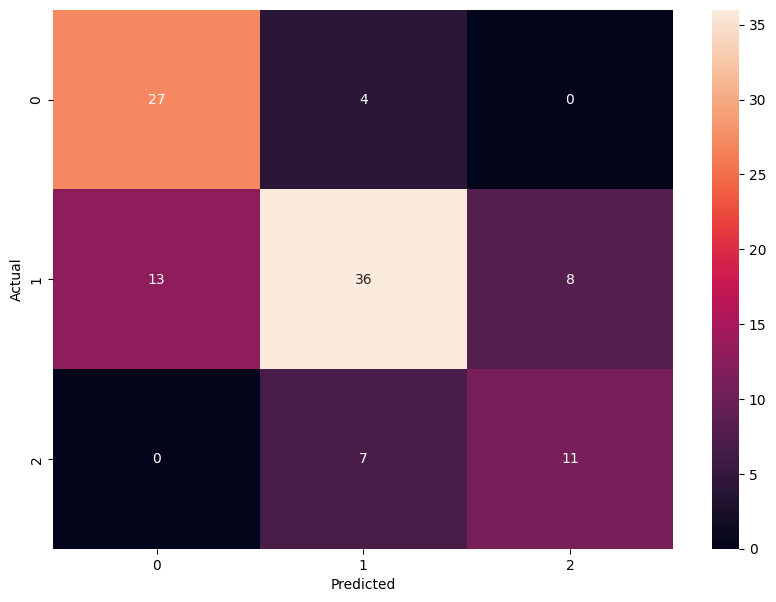

In [58]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 평가를 위한 설정
model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/model/model_v6/YCbCr_resnet50_0.0001_3_3_pigmentation_classification_model_v2.pth'

val_dataset = SkinDataset(csv_file="/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/res/annotation.csv",
                          image_folder='/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_r_images_val',
                          transform=transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 모델 로드 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_save_path)
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # val_loader로 변경
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 그리기
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Batch Normalization 추가

In [ ]:
# ! pip install optuna

In [65]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import ResNet50_Weights

class ResNetforClassification(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(ResNetforClassification, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.dropout = nn.Dropout(p=dropout_rate)  # 드롭아웃 비율
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            self.dropout,
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
    dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)

    model = ResNetforClassification(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

    best_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5)
    val_acc = evaluate_model(best_model, val_loader)
    return val_acc

def evaluate_model(model, dataloader):
    model.eval()
    val_corrects = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_total += labels.size(0)
    return val_corrects.double() / val_total

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # 50개의 trial을 수행하여 하이퍼파라미터 최적화

# 최적화된 하이퍼파라미터 출력
print("Best hyperparameters:", study.best_params)
print("Best validation accuracy:", study.best_value)



[I 2024-08-20 08:07:19,102] A new study created in memory with name: no-name-45470ab1-5755-43f5-be1d-76dcf1457a6b
<ipython-input-65-197801b5bc11>:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-65-197801b5bc11>:35: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
<ipython-input-65-197801b5bc11>:36: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout', 0.1, 0.5)


Epoch [1/50], Train Loss: 1.0829, Train Accuracy: 0.3026, Val Loss: 1.0832, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.9674, Train Accuracy: 0.4727, Val Loss: 1.0483, Val Accuracy: 0.3372
Epoch [3/50], Train Loss: 0.8502, Train Accuracy: 0.5597, Val Loss: 1.1005, Val Accuracy: 0.3488
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.7576, Train Accuracy: 0.6597, Val Loss: 0.8961, Val Accuracy: 0.5581
Epoch [5/50], Train Loss: 0.6665, Train Accuracy: 0.7688, Val Loss: 0.8244, Val Accuracy: 0.6279
Epoch [6/50], Train Loss: 0.5998, Train Accuracy: 0.8130, Val Loss: 0.8037, Val Accuracy: 0.6977
Epoch [7/50], Train Loss: 0.5120, Train Accuracy: 0.8701, Val Loss: 0.7850, Val Accuracy: 0.7326
Epoch [8/50], Train Loss: 0.4388, Train Accuracy: 0.9065, Val Loss: 0.7918, Val Accuracy: 0.7093
EarlyStopping counter: 1 out of 5
Epoch [9/50], Train Loss: 0.3790, Train Accuracy: 0.9325, Val Loss: 0.7510, Val Accuracy: 0.7209
Epoch [10/50], Train Loss: 0.3199, Train Accuracy: 0.9558, 

[I 2024-08-20 08:08:41,724] Trial 0 finished with value: 0.7558139534883721 and parameters: {'lr': 4.9890383812712954e-05, 'weight_decay': 0.0005758607549394959, 'dropout': 0.26571919785477727}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.4065, Train Accuracy: 0.3831, Val Loss: 484852.6170, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 1.0940, Train Accuracy: 0.4519, Val Loss: 18.9779, Val Accuracy: 0.3721
Epoch [3/50], Train Loss: 1.0594, Train Accuracy: 0.4286, Val Loss: 16.4479, Val Accuracy: 0.2209
Epoch [4/50], Train Loss: 1.0339, Train Accuracy: 0.4481, Val Loss: 1.1236, Val Accuracy: 0.3837
Epoch [5/50], Train Loss: 1.0274, Train Accuracy: 0.4636, Val Loss: 1.2143, Val Accuracy: 0.3837
EarlyStopping counter: 1 out of 5
Epoch [6/50], Train Loss: 1.0219, Train Accuracy: 0.4740, Val Loss: 1.4560, Val Accuracy: 0.4767
EarlyStopping counter: 2 out of 5
Epoch [7/50], Train Loss: 0.9867, Train Accuracy: 0.4883, Val Loss: 1.1494, Val Accuracy: 0.4186
EarlyStopping counter: 3 out of 5
Epoch [8/50], Train Loss: 0.9819, Train Accuracy: 0.4857, Val Loss: 1.0266, Val Accuracy: 0.5000
Epoch [9/50], Train Loss: 0.9638, Train Accuracy: 0.5195, Val Loss: 1.1906, Val Accuracy: 0.4186
EarlyStopping coun

[I 2024-08-20 08:11:38,151] Trial 1 finished with value: 0.6162790697674418 and parameters: {'lr': 0.009084460529358955, 'weight_decay': 0.0003574067028637786, 'dropout': 0.40991141512235985}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0945, Train Accuracy: 0.4909, Val Loss: 1.0965, Val Accuracy: 0.4302
Epoch [2/50], Train Loss: 1.0671, Train Accuracy: 0.6312, Val Loss: 1.0951, Val Accuracy: 0.5000
Epoch [3/50], Train Loss: 1.0405, Train Accuracy: 0.6532, Val Loss: 1.1058, Val Accuracy: 0.2674
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 1.0146, Train Accuracy: 0.6390, Val Loss: 1.0552, Val Accuracy: 0.4767
Epoch [5/50], Train Loss: 0.9893, Train Accuracy: 0.6377, Val Loss: 1.0329, Val Accuracy: 0.5465
Epoch [6/50], Train Loss: 0.9606, Train Accuracy: 0.6273, Val Loss: 1.0136, Val Accuracy: 0.5814
Epoch [7/50], Train Loss: 0.9238, Train Accuracy: 0.6260, Val Loss: 0.9860, Val Accuracy: 0.6047
Epoch [8/50], Train Loss: 0.8970, Train Accuracy: 0.6143, Val Loss: 0.9629, Val Accuracy: 0.5930
Epoch [9/50], Train Loss: 0.8681, Train Accuracy: 0.6208, Val Loss: 0.9624, Val Accuracy: 0.6047
Epoch [10/50], Train Loss: 0.8479, Train Accuracy: 0.6377, Val Loss: 0.9439, Val Accuracy: 0.

[I 2024-08-20 08:13:52,295] Trial 2 finished with value: 0.6511627906976745 and parameters: {'lr': 1.2658005671253975e-05, 'weight_decay': 7.645550469725275e-05, 'dropout': 0.22514689698843046}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 20.0111, Train Accuracy: 0.3844, Val Loss: 29731564329.6744, Val Accuracy: 0.1860
Epoch [2/50], Train Loss: 5.7378, Train Accuracy: 0.4870, Val Loss: 135054.5218, Val Accuracy: 0.3372
Epoch [3/50], Train Loss: 3.3420, Train Accuracy: 0.4948, Val Loss: 353.9916, Val Accuracy: 0.4651
Epoch [4/50], Train Loss: 1.9399, Train Accuracy: 0.4039, Val Loss: 4.9179, Val Accuracy: 0.3837
Epoch [5/50], Train Loss: 1.5008, Train Accuracy: 0.4195, Val Loss: 1.1931, Val Accuracy: 0.4767
Epoch [6/50], Train Loss: 1.2514, Train Accuracy: 0.3649, Val Loss: 1.9669, Val Accuracy: 0.3372
EarlyStopping counter: 1 out of 5
Epoch [7/50], Train Loss: 1.2178, Train Accuracy: 0.3935, Val Loss: 1.1239, Val Accuracy: 0.3488
Epoch [8/50], Train Loss: 1.0919, Train Accuracy: 0.3468, Val Loss: 1.0786, Val Accuracy: 0.3605
Epoch [9/50], Train Loss: 1.0878, Train Accuracy: 0.4792, Val Loss: 1.0776, Val Accuracy: 0.4884
Epoch [10/50], Train Loss: 1.0992, Train Accuracy: 0.3987, Val Loss: 1.0654

[I 2024-08-20 08:15:18,792] Trial 3 finished with value: 0.4883720930232558 and parameters: {'lr': 0.04621429758937831, 'weight_decay': 0.0029646325331498047, 'dropout': 0.4799503189101545}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0165, Train Accuracy: 0.5494, Val Loss: 1.0665, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.7596, Train Accuracy: 0.6883, Val Loss: 1.0717, Val Accuracy: 0.3488
EarlyStopping counter: 1 out of 5
Epoch [3/50], Train Loss: 0.4892, Train Accuracy: 0.8182, Val Loss: 0.8299, Val Accuracy: 0.6395
Epoch [4/50], Train Loss: 0.2498, Train Accuracy: 0.9377, Val Loss: 1.1842, Val Accuracy: 0.6395
EarlyStopping counter: 1 out of 5
Epoch [5/50], Train Loss: 0.0886, Train Accuracy: 0.9857, Val Loss: 0.9613, Val Accuracy: 0.6628
EarlyStopping counter: 2 out of 5
Epoch [6/50], Train Loss: 0.0600, Train Accuracy: 0.9688, Val Loss: 1.2227, Val Accuracy: 0.6047
EarlyStopping counter: 3 out of 5
Epoch [7/50], Train Loss: 0.0328, Train Accuracy: 0.9896, Val Loss: 1.4536, Val Accuracy: 0.6860
EarlyStopping counter: 4 out of 5
Epoch [8/50], Train Loss: 0.0296, Train Accuracy: 0.9909, Val Loss: 1.3393, Val Accuracy: 0.6860
EarlyStopping counter: 5 out of 5
Early stopping


[I 2024-08-20 08:16:07,397] Trial 4 finished with value: 0.686046511627907 and parameters: {'lr': 0.00017554815837017448, 'weight_decay': 0.0005292815508771409, 'dropout': 0.24118947656275525}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0138, Train Accuracy: 0.5169, Val Loss: 1.0540, Val Accuracy: 0.3721
Epoch [2/50], Train Loss: 0.7376, Train Accuracy: 0.6896, Val Loss: 1.0442, Val Accuracy: 0.4302
Epoch [3/50], Train Loss: 0.4588, Train Accuracy: 0.8429, Val Loss: 1.0150, Val Accuracy: 0.5000
Epoch [4/50], Train Loss: 0.2602, Train Accuracy: 0.9286, Val Loss: 0.8540, Val Accuracy: 0.6860
Epoch [5/50], Train Loss: 0.1629, Train Accuracy: 0.9506, Val Loss: 0.9204, Val Accuracy: 0.6395
EarlyStopping counter: 1 out of 5
Epoch [6/50], Train Loss: 0.1083, Train Accuracy: 0.9766, Val Loss: 0.9195, Val Accuracy: 0.6163
EarlyStopping counter: 2 out of 5
Epoch [7/50], Train Loss: 0.0426, Train Accuracy: 0.9961, Val Loss: 1.2570, Val Accuracy: 0.5465
EarlyStopping counter: 3 out of 5
Epoch [8/50], Train Loss: 0.0393, Train Accuracy: 0.9961, Val Loss: 1.2541, Val Accuracy: 0.6279
EarlyStopping counter: 4 out of 5
Epoch [9/50], Train Loss: 0.0180, Train Accuracy: 0.9961, Val Loss: 1.1226, Val Accuracy

[I 2024-08-20 08:17:00,782] Trial 5 finished with value: 0.686046511627907 and parameters: {'lr': 0.0001536136442634414, 'weight_decay': 0.07296648243908484, 'dropout': 0.10489079205419026}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 0.9892, Train Accuracy: 0.4831, Val Loss: 1.0160, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.6824, Train Accuracy: 0.7234, Val Loss: 1.0349, Val Accuracy: 0.4535
EarlyStopping counter: 1 out of 5
Epoch [3/50], Train Loss: 0.4053, Train Accuracy: 0.8519, Val Loss: 1.0115, Val Accuracy: 0.5698
Epoch [4/50], Train Loss: 0.2354, Train Accuracy: 0.9052, Val Loss: 0.9850, Val Accuracy: 0.6512
Epoch [5/50], Train Loss: 0.1560, Train Accuracy: 0.9403, Val Loss: 0.9475, Val Accuracy: 0.6279
Epoch [6/50], Train Loss: 0.0896, Train Accuracy: 0.9688, Val Loss: 1.3202, Val Accuracy: 0.6395
EarlyStopping counter: 1 out of 5
Epoch [7/50], Train Loss: 0.0982, Train Accuracy: 0.9701, Val Loss: 0.8407, Val Accuracy: 0.6395
Epoch [8/50], Train Loss: 0.0609, Train Accuracy: 0.9844, Val Loss: 0.9990, Val Accuracy: 0.6628
EarlyStopping counter: 1 out of 5
Epoch [9/50], Train Loss: 0.0630, Train Accuracy: 0.9792, Val Loss: 0.9345, Val Accuracy: 0.6744
EarlyStopping counter: 2 

[I 2024-08-20 08:19:03,892] Trial 6 finished with value: 0.7441860465116279 and parameters: {'lr': 0.00020405378211237074, 'weight_decay': 2.742302995576539e-05, 'dropout': 0.182315505638144}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 0.9834, Train Accuracy: 0.5234, Val Loss: 1.0669, Val Accuracy: 0.5233
Epoch [2/50], Train Loss: 0.8017, Train Accuracy: 0.5987, Val Loss: 1.0148, Val Accuracy: 0.4419
Epoch [3/50], Train Loss: 0.7235, Train Accuracy: 0.6130, Val Loss: 0.7849, Val Accuracy: 0.5465
Epoch [4/50], Train Loss: 0.7458, Train Accuracy: 0.5857, Val Loss: 0.7777, Val Accuracy: 0.6395
Epoch [5/50], Train Loss: 0.6670, Train Accuracy: 0.6987, Val Loss: 0.5886, Val Accuracy: 0.6744
Epoch [6/50], Train Loss: 0.5964, Train Accuracy: 0.7182, Val Loss: 0.7670, Val Accuracy: 0.6047
EarlyStopping counter: 1 out of 5
Epoch [7/50], Train Loss: 0.5912, Train Accuracy: 0.7221, Val Loss: 1.1664, Val Accuracy: 0.5465
EarlyStopping counter: 2 out of 5
Epoch [8/50], Train Loss: 0.4938, Train Accuracy: 0.7649, Val Loss: 1.0270, Val Accuracy: 0.4535
EarlyStopping counter: 3 out of 5
Epoch [9/50], Train Loss: 0.3348, Train Accuracy: 0.8506, Val Loss: 1.0837, Val Accuracy: 0.5233
EarlyStopping counter: 4 

[I 2024-08-20 08:20:02,845] Trial 7 finished with value: 0.6744186046511628 and parameters: {'lr': 0.0012380386461997735, 'weight_decay': 7.154265048724629e-05, 'dropout': 0.4199879153991478}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 0.9831, Train Accuracy: 0.4766, Val Loss: 14.9947, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.9379, Train Accuracy: 0.5286, Val Loss: 7.4856, Val Accuracy: 0.2558
Epoch [3/50], Train Loss: 0.8822, Train Accuracy: 0.5351, Val Loss: 1.7328, Val Accuracy: 0.4302
Epoch [4/50], Train Loss: 0.8531, Train Accuracy: 0.5701, Val Loss: 2.2724, Val Accuracy: 0.2907
EarlyStopping counter: 1 out of 5
Epoch [5/50], Train Loss: 0.8209, Train Accuracy: 0.5325, Val Loss: 0.9655, Val Accuracy: 0.5116
Epoch [6/50], Train Loss: 0.8329, Train Accuracy: 0.5468, Val Loss: 0.7959, Val Accuracy: 0.5465
Epoch [7/50], Train Loss: 0.7669, Train Accuracy: 0.5455, Val Loss: 0.7841, Val Accuracy: 0.6279
Epoch [8/50], Train Loss: 0.7305, Train Accuracy: 0.5922, Val Loss: 1.0214, Val Accuracy: 0.3837
EarlyStopping counter: 1 out of 5
Epoch [9/50], Train Loss: 0.6537, Train Accuracy: 0.6649, Val Loss: 0.6798, Val Accuracy: 0.5930
Epoch [10/50], Train Loss: 0.6794, Train Accuracy: 0.6377,

[I 2024-08-20 08:22:04,595] Trial 8 finished with value: 0.686046511627907 and parameters: {'lr': 0.0023665343645624974, 'weight_decay': 4.975677931732834e-05, 'dropout': 0.27120682251239847}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 0.9881, Train Accuracy: 0.5208, Val Loss: 0.9352, Val Accuracy: 0.6628
Epoch [2/50], Train Loss: 0.6538, Train Accuracy: 0.7312, Val Loss: 0.9130, Val Accuracy: 0.4535
Epoch [3/50], Train Loss: 0.3602, Train Accuracy: 0.8545, Val Loss: 1.2921, Val Accuracy: 0.6512
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.2160, Train Accuracy: 0.9143, Val Loss: 2.0344, Val Accuracy: 0.5814
EarlyStopping counter: 2 out of 5
Epoch [5/50], Train Loss: 0.1782, Train Accuracy: 0.9182, Val Loss: 1.6506, Val Accuracy: 0.6744
EarlyStopping counter: 3 out of 5
Epoch [6/50], Train Loss: 0.1149, Train Accuracy: 0.9584, Val Loss: 1.2094, Val Accuracy: 0.6512
EarlyStopping counter: 4 out of 5
Epoch [7/50], Train Loss: 0.1384, Train Accuracy: 0.9468, Val Loss: 1.5244, Val Accuracy: 0.6279
EarlyStopping counter: 5 out of 5
Early stopping


[I 2024-08-20 08:22:46,124] Trial 9 finished with value: 0.6744186046511628 and parameters: {'lr': 0.00031125800208502754, 'weight_decay': 1.1212533705697584e-05, 'dropout': 0.41927194236135057}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0948, Train Accuracy: 0.3662, Val Loss: 1.0954, Val Accuracy: 0.3256
Epoch [2/50], Train Loss: 1.0682, Train Accuracy: 0.4870, Val Loss: 1.0898, Val Accuracy: 0.3372
Epoch [3/50], Train Loss: 1.0516, Train Accuracy: 0.4688, Val Loss: 1.0827, Val Accuracy: 0.3372
Epoch [4/50], Train Loss: 1.0321, Train Accuracy: 0.4584, Val Loss: 1.0512, Val Accuracy: 0.3488
Epoch [5/50], Train Loss: 1.0097, Train Accuracy: 0.4468, Val Loss: 1.0316, Val Accuracy: 0.4186
Epoch [6/50], Train Loss: 0.9822, Train Accuracy: 0.4714, Val Loss: 1.0189, Val Accuracy: 0.4186
Epoch [7/50], Train Loss: 0.9583, Train Accuracy: 0.5039, Val Loss: 1.0032, Val Accuracy: 0.5000
Epoch [8/50], Train Loss: 0.9310, Train Accuracy: 0.5208, Val Loss: 0.9844, Val Accuracy: 0.4884
Epoch [9/50], Train Loss: 0.9101, Train Accuracy: 0.5351, Val Loss: 0.9748, Val Accuracy: 0.5581
Epoch [10/50], Train Loss: 0.8847, Train Accuracy: 0.5662, Val Loss: 0.9572, Val Accuracy: 0.5581
Epoch [11/50], Train Loss: 0.

[I 2024-08-20 08:24:53,986] Trial 10 finished with value: 0.6162790697674418 and parameters: {'lr': 1.2744413173903821e-05, 'weight_decay': 0.006127381703786684, 'dropout': 0.33623726527071596}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0687, Train Accuracy: 0.3584, Val Loss: 1.0785, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.9642, Train Accuracy: 0.5623, Val Loss: 1.0692, Val Accuracy: 0.4070
Epoch [3/50], Train Loss: 0.8484, Train Accuracy: 0.6065, Val Loss: 1.0262, Val Accuracy: 0.3488
Epoch [4/50], Train Loss: 0.7447, Train Accuracy: 0.7117, Val Loss: 0.9086, Val Accuracy: 0.5814
Epoch [5/50], Train Loss: 0.6367, Train Accuracy: 0.7390, Val Loss: 0.8109, Val Accuracy: 0.6512
Epoch [6/50], Train Loss: 0.5205, Train Accuracy: 0.8260, Val Loss: 0.8500, Val Accuracy: 0.6628
EarlyStopping counter: 1 out of 5
Epoch [7/50], Train Loss: 0.4321, Train Accuracy: 0.8714, Val Loss: 0.8251, Val Accuracy: 0.6860
EarlyStopping counter: 2 out of 5
Epoch [8/50], Train Loss: 0.3384, Train Accuracy: 0.9377, Val Loss: 0.8306, Val Accuracy: 0.7093
EarlyStopping counter: 3 out of 5
Epoch [9/50], Train Loss: 0.2870, Train Accuracy: 0.9545, Val Loss: 0.9230, Val Accuracy: 0.6977
EarlyStopping counter: 4 

[I 2024-08-20 08:25:55,203] Trial 11 finished with value: 0.7093023255813954 and parameters: {'lr': 4.69220088040406e-05, 'weight_decay': 1.1142167163079648e-05, 'dropout': 0.15359136240876303}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0661, Train Accuracy: 0.3481, Val Loss: 1.0803, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.9235, Train Accuracy: 0.6065, Val Loss: 1.0320, Val Accuracy: 0.3605
Epoch [3/50], Train Loss: 0.7813, Train Accuracy: 0.6636, Val Loss: 1.0261, Val Accuracy: 0.3605
Epoch [4/50], Train Loss: 0.6712, Train Accuracy: 0.8065, Val Loss: 0.8222, Val Accuracy: 0.6512
Epoch [5/50], Train Loss: 0.5353, Train Accuracy: 0.8727, Val Loss: 0.7732, Val Accuracy: 0.7209
Epoch [6/50], Train Loss: 0.4209, Train Accuracy: 0.9039, Val Loss: 0.7942, Val Accuracy: 0.7209
EarlyStopping counter: 1 out of 5
Epoch [7/50], Train Loss: 0.3218, Train Accuracy: 0.9468, Val Loss: 0.8223, Val Accuracy: 0.6628
EarlyStopping counter: 2 out of 5
Epoch [8/50], Train Loss: 0.2723, Train Accuracy: 0.9455, Val Loss: 0.8502, Val Accuracy: 0.5930
EarlyStopping counter: 3 out of 5
Epoch [9/50], Train Loss: 0.2195, Train Accuracy: 0.9623, Val Loss: 0.8372, Val Accuracy: 0.5930
EarlyStopping counter: 4 

[I 2024-08-20 08:26:54,307] Trial 12 finished with value: 0.7209302325581395 and parameters: {'lr': 6.35528295472167e-05, 'weight_decay': 0.011231877993150367, 'dropout': 0.17811965514865374}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 0.9316, Train Accuracy: 0.5506, Val Loss: 1.0760, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.6139, Train Accuracy: 0.7247, Val Loss: 1.0916, Val Accuracy: 0.3256
EarlyStopping counter: 1 out of 5
Epoch [3/50], Train Loss: 0.4610, Train Accuracy: 0.7766, Val Loss: 1.8489, Val Accuracy: 0.4767
EarlyStopping counter: 2 out of 5
Epoch [4/50], Train Loss: 0.3701, Train Accuracy: 0.8364, Val Loss: 0.9152, Val Accuracy: 0.5233
Epoch [5/50], Train Loss: 0.1978, Train Accuracy: 0.9338, Val Loss: 1.2775, Val Accuracy: 0.5814
EarlyStopping counter: 1 out of 5
Epoch [6/50], Train Loss: 0.1808, Train Accuracy: 0.9273, Val Loss: 2.5459, Val Accuracy: 0.6279
EarlyStopping counter: 2 out of 5
Epoch [7/50], Train Loss: 0.2705, Train Accuracy: 0.9104, Val Loss: 1.9874, Val Accuracy: 0.5000
EarlyStopping counter: 3 out of 5
Epoch [8/50], Train Loss: 0.2975, Train Accuracy: 0.8623, Val Loss: 1.6055, Val Accuracy: 0.6279
EarlyStopping counter: 4 out of 5
Epoch [9/50], Train 

[I 2024-08-20 08:27:48,651] Trial 13 finished with value: 0.627906976744186 and parameters: {'lr': 0.000508576597492256, 'weight_decay': 0.00026001668997913824, 'dropout': 0.32433682845475775}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0685, Train Accuracy: 0.5091, Val Loss: 1.0849, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.9701, Train Accuracy: 0.4961, Val Loss: 1.0665, Val Accuracy: 0.3372
Epoch [3/50], Train Loss: 0.8509, Train Accuracy: 0.5818, Val Loss: 1.0516, Val Accuracy: 0.3488
Epoch [4/50], Train Loss: 0.7480, Train Accuracy: 0.7351, Val Loss: 0.9083, Val Accuracy: 0.5465
Epoch [5/50], Train Loss: 0.6559, Train Accuracy: 0.8104, Val Loss: 0.8321, Val Accuracy: 0.6628
Epoch [6/50], Train Loss: 0.5611, Train Accuracy: 0.8325, Val Loss: 0.8336, Val Accuracy: 0.6744
EarlyStopping counter: 1 out of 5
Epoch [7/50], Train Loss: 0.4523, Train Accuracy: 0.8818, Val Loss: 0.8302, Val Accuracy: 0.6860
Epoch [8/50], Train Loss: 0.3815, Train Accuracy: 0.9234, Val Loss: 0.7818, Val Accuracy: 0.6163
Epoch [9/50], Train Loss: 0.3259, Train Accuracy: 0.9519, Val Loss: 0.8048, Val Accuracy: 0.6163
EarlyStopping counter: 1 out of 5
Epoch [10/50], Train Loss: 0.2715, Train Accuracy: 0.9597, 

[I 2024-08-20 08:29:05,823] Trial 14 finished with value: 0.686046511627907 and parameters: {'lr': 4.725343884159056e-05, 'weight_decay': 0.0021069981502815395, 'dropout': 0.2009474931155224}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.2413, Train Accuracy: 0.3935, Val Loss: 48322.4978, Val Accuracy: 0.4767
Epoch [2/50], Train Loss: 1.0832, Train Accuracy: 0.5091, Val Loss: 3.3571, Val Accuracy: 0.4651
Epoch [3/50], Train Loss: 1.0477, Train Accuracy: 0.4935, Val Loss: 1.1116, Val Accuracy: 0.4419
Epoch [4/50], Train Loss: 0.9963, Train Accuracy: 0.4974, Val Loss: 1.0905, Val Accuracy: 0.4651
Epoch [5/50], Train Loss: 1.0286, Train Accuracy: 0.4649, Val Loss: 1.0554, Val Accuracy: 0.4419
Epoch [6/50], Train Loss: 1.0004, Train Accuracy: 0.5273, Val Loss: 1.5282, Val Accuracy: 0.3488
EarlyStopping counter: 1 out of 5
Epoch [7/50], Train Loss: 0.9356, Train Accuracy: 0.5286, Val Loss: 0.9330, Val Accuracy: 0.5116
Epoch [8/50], Train Loss: 0.9164, Train Accuracy: 0.5532, Val Loss: 1.3435, Val Accuracy: 0.5233
EarlyStopping counter: 1 out of 5
Epoch [9/50], Train Loss: 0.8756, Train Accuracy: 0.5727, Val Loss: 1.0208, Val Accuracy: 0.4884
EarlyStopping counter: 2 out of 5
Epoch [10/50], Train 

[I 2024-08-20 08:31:11,111] Trial 15 finished with value: 0.5930232558139534 and parameters: {'lr': 0.004621194321108368, 'weight_decay': 0.023083149465088666, 'dropout': 0.1134500909626125}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0478, Train Accuracy: 0.4429, Val Loss: 1.0711, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.8565, Train Accuracy: 0.6026, Val Loss: 1.0372, Val Accuracy: 0.3721
Epoch [3/50], Train Loss: 0.7002, Train Accuracy: 0.7494, Val Loss: 1.2337, Val Accuracy: 0.3721
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.5296, Train Accuracy: 0.8584, Val Loss: 0.8951, Val Accuracy: 0.5233
Epoch [5/50], Train Loss: 0.3812, Train Accuracy: 0.9078, Val Loss: 0.8097, Val Accuracy: 0.6860
Epoch [6/50], Train Loss: 0.2733, Train Accuracy: 0.9519, Val Loss: 0.7759, Val Accuracy: 0.7093
Epoch [7/50], Train Loss: 0.2045, Train Accuracy: 0.9675, Val Loss: 0.8350, Val Accuracy: 0.7093
EarlyStopping counter: 1 out of 5
Epoch [8/50], Train Loss: 0.1423, Train Accuracy: 0.9805, Val Loss: 0.8618, Val Accuracy: 0.6047
EarlyStopping counter: 2 out of 5
Epoch [9/50], Train Loss: 0.0902, Train Accuracy: 0.9883, Val Loss: 0.8946, Val Accuracy: 0.6628
EarlyStopping counter: 3 

[I 2024-08-20 08:32:16,237] Trial 16 finished with value: 0.7093023255813954 and parameters: {'lr': 9.332823384311859e-05, 'weight_decay': 0.0011053722421792628, 'dropout': 0.27898140059355336}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 0.9637, Train Accuracy: 0.5260, Val Loss: 1.5699, Val Accuracy: 0.3721
Epoch [2/50], Train Loss: 0.7057, Train Accuracy: 0.6987, Val Loss: 1.0145, Val Accuracy: 0.4884
Epoch [3/50], Train Loss: 0.4960, Train Accuracy: 0.7571, Val Loss: 1.1854, Val Accuracy: 0.5465
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.4394, Train Accuracy: 0.7390, Val Loss: 1.0958, Val Accuracy: 0.6977
EarlyStopping counter: 2 out of 5
Epoch [5/50], Train Loss: 0.4114, Train Accuracy: 0.8377, Val Loss: 1.0723, Val Accuracy: 0.5000
EarlyStopping counter: 3 out of 5
Epoch [6/50], Train Loss: 0.3736, Train Accuracy: 0.8377, Val Loss: 0.9964, Val Accuracy: 0.6047
Epoch [7/50], Train Loss: 0.2285, Train Accuracy: 0.9130, Val Loss: 0.7528, Val Accuracy: 0.6047
Epoch [8/50], Train Loss: 0.3110, Train Accuracy: 0.8610, Val Loss: 1.4595, Val Accuracy: 0.4535
EarlyStopping counter: 1 out of 5
Epoch [9/50], Train Loss: 0.1945, Train Accuracy: 0.9338, Val Loss: 1.4053, Val Accuracy

[I 2024-08-20 08:33:26,714] Trial 17 finished with value: 0.6976744186046512 and parameters: {'lr': 0.0005649094318128064, 'weight_decay': 0.0001678022282001662, 'dropout': 0.3577814837683377}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0766, Train Accuracy: 0.4377, Val Loss: 1.0915, Val Accuracy: 0.3256
Epoch [2/50], Train Loss: 1.0018, Train Accuracy: 0.5247, Val Loss: 1.0703, Val Accuracy: 0.3372
Epoch [3/50], Train Loss: 0.9168, Train Accuracy: 0.5390, Val Loss: 1.0665, Val Accuracy: 0.3488
Epoch [4/50], Train Loss: 0.8269, Train Accuracy: 0.6338, Val Loss: 0.9313, Val Accuracy: 0.5698
Epoch [5/50], Train Loss: 0.7559, Train Accuracy: 0.7364, Val Loss: 0.8578, Val Accuracy: 0.6512
Epoch [6/50], Train Loss: 0.6850, Train Accuracy: 0.7338, Val Loss: 0.8224, Val Accuracy: 0.6279
Epoch [7/50], Train Loss: 0.6092, Train Accuracy: 0.7753, Val Loss: 0.8339, Val Accuracy: 0.6977
EarlyStopping counter: 1 out of 5
Epoch [8/50], Train Loss: 0.5563, Train Accuracy: 0.8052, Val Loss: 0.8234, Val Accuracy: 0.6744
EarlyStopping counter: 2 out of 5
Epoch [9/50], Train Loss: 0.4775, Train Accuracy: 0.8545, Val Loss: 0.7872, Val Accuracy: 0.6860
Epoch [10/50], Train Loss: 0.4293, Train Accuracy: 0.8961, 

[I 2024-08-20 08:34:56,233] Trial 18 finished with value: 0.7325581395348837 and parameters: {'lr': 3.582107964753036e-05, 'weight_decay': 2.7395719754631398e-05, 'dropout': 0.15901694860999965}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 99.4814, Train Accuracy: 0.3974, Val Loss: 5693472798481.8604, Val Accuracy: 0.4767
Epoch [2/50], Train Loss: 14.2356, Train Accuracy: 0.4701, Val Loss: 76692.6628, Val Accuracy: 0.1977
Epoch [3/50], Train Loss: 2.6864, Train Accuracy: 0.3364, Val Loss: 774.8379, Val Accuracy: 0.3605
Epoch [4/50], Train Loss: 3.3930, Train Accuracy: 0.3857, Val Loss: 51.4019, Val Accuracy: 0.4535
Epoch [5/50], Train Loss: 1.8167, Train Accuracy: 0.3753, Val Loss: 68.3694, Val Accuracy: 0.4070
EarlyStopping counter: 1 out of 5
Epoch [6/50], Train Loss: 1.4827, Train Accuracy: 0.3208, Val Loss: 1.0648, Val Accuracy: 0.4302
Epoch [7/50], Train Loss: 1.2555, Train Accuracy: 0.3065, Val Loss: 1.0857, Val Accuracy: 0.3837
EarlyStopping counter: 1 out of 5
Epoch [8/50], Train Loss: 1.1002, Train Accuracy: 0.3351, Val Loss: 1.1228, Val Accuracy: 0.4767
EarlyStopping counter: 2 out of 5
Epoch [9/50], Train Loss: 1.1270, Train Accuracy: 0.3506, Val Loss: 1.0796, Val Accuracy: 0.3953
Ear

[I 2024-08-20 08:35:58,811] Trial 19 finished with value: 0.47674418604651164 and parameters: {'lr': 0.09837326839344912, 'weight_decay': 0.00014942247043612522, 'dropout': 0.24188375839002005}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0814, Train Accuracy: 0.4039, Val Loss: 1.0963, Val Accuracy: 0.4651
Epoch [2/50], Train Loss: 1.0273, Train Accuracy: 0.4792, Val Loss: 1.0880, Val Accuracy: 0.4070
Epoch [3/50], Train Loss: 0.9780, Train Accuracy: 0.5143, Val Loss: 1.0719, Val Accuracy: 0.3488
Epoch [4/50], Train Loss: 0.9304, Train Accuracy: 0.4818, Val Loss: 0.9939, Val Accuracy: 0.3721
Epoch [5/50], Train Loss: 0.8598, Train Accuracy: 0.6104, Val Loss: 0.9250, Val Accuracy: 0.5930
Epoch [6/50], Train Loss: 0.8171, Train Accuracy: 0.6753, Val Loss: 0.9103, Val Accuracy: 0.6163
Epoch [7/50], Train Loss: 0.7675, Train Accuracy: 0.6909, Val Loss: 0.8777, Val Accuracy: 0.6395
Epoch [8/50], Train Loss: 0.7129, Train Accuracy: 0.7545, Val Loss: 0.8768, Val Accuracy: 0.6163
Epoch [9/50], Train Loss: 0.6777, Train Accuracy: 0.7442, Val Loss: 0.8498, Val Accuracy: 0.6395
Epoch [10/50], Train Loss: 0.6351, Train Accuracy: 0.7623, Val Loss: 0.8326, Val Accuracy: 0.6279
Epoch [11/50], Train Loss: 0.

[I 2024-08-20 08:38:12,259] Trial 20 finished with value: 0.686046511627907 and parameters: {'lr': 2.6978354061600803e-05, 'weight_decay': 0.0008950073048034098, 'dropout': 0.29629659001032776}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0853, Train Accuracy: 0.4429, Val Loss: 1.0970, Val Accuracy: 0.3140
Epoch [2/50], Train Loss: 1.0409, Train Accuracy: 0.4974, Val Loss: 1.0925, Val Accuracy: 0.3721
Epoch [3/50], Train Loss: 1.0004, Train Accuracy: 0.5805, Val Loss: 1.0961, Val Accuracy: 0.3488
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.9481, Train Accuracy: 0.5623, Val Loss: 1.0203, Val Accuracy: 0.3837
Epoch [5/50], Train Loss: 0.8885, Train Accuracy: 0.5818, Val Loss: 0.9623, Val Accuracy: 0.5698
Epoch [6/50], Train Loss: 0.8486, Train Accuracy: 0.6286, Val Loss: 0.9324, Val Accuracy: 0.5930
Epoch [7/50], Train Loss: 0.7942, Train Accuracy: 0.6390, Val Loss: 0.8990, Val Accuracy: 0.6163
Epoch [8/50], Train Loss: 0.7600, Train Accuracy: 0.6675, Val Loss: 0.8823, Val Accuracy: 0.6279
Epoch [9/50], Train Loss: 0.7258, Train Accuracy: 0.7065, Val Loss: 0.8672, Val Accuracy: 0.6628
Epoch [10/50], Train Loss: 0.6848, Train Accuracy: 0.7416, Val Loss: 0.8535, Val Accuracy: 0.

[I 2024-08-20 08:42:25,519] Trial 21 finished with value: 0.7209302325581395 and parameters: {'lr': 2.1771960548704638e-05, 'weight_decay': 3.067855847501262e-05, 'dropout': 0.15139101730672339}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0183, Train Accuracy: 0.5766, Val Loss: 1.0735, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.7584, Train Accuracy: 0.6948, Val Loss: 1.0592, Val Accuracy: 0.3605
Epoch [3/50], Train Loss: 0.5116, Train Accuracy: 0.7831, Val Loss: 1.3994, Val Accuracy: 0.4651
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.3183, Train Accuracy: 0.9468, Val Loss: 0.9134, Val Accuracy: 0.6279
Epoch [5/50], Train Loss: 0.2118, Train Accuracy: 0.9416, Val Loss: 0.9069, Val Accuracy: 0.7093
Epoch [6/50], Train Loss: 0.1405, Train Accuracy: 0.9701, Val Loss: 1.0390, Val Accuracy: 0.6628
EarlyStopping counter: 1 out of 5
Epoch [7/50], Train Loss: 0.1075, Train Accuracy: 0.9636, Val Loss: 0.8894, Val Accuracy: 0.6279
Epoch [8/50], Train Loss: 0.0981, Train Accuracy: 0.9779, Val Loss: 0.8644, Val Accuracy: 0.6628
Epoch [9/50], Train Loss: 0.0636, Train Accuracy: 0.9883, Val Loss: 0.9541, Val Accuracy: 0.6512
EarlyStopping counter: 1 out of 5
Epoch [10/50], Train Loss

[I 2024-08-20 08:43:42,265] Trial 22 finished with value: 0.7093023255813954 and parameters: {'lr': 0.0001502333000083656, 'weight_decay': 2.3891163468467202e-05, 'dropout': 0.18779631802970606}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0807, Train Accuracy: 0.3130, Val Loss: 1.0878, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 1.0001, Train Accuracy: 0.3662, Val Loss: 1.0763, Val Accuracy: 0.3372
Epoch [3/50], Train Loss: 0.9200, Train Accuracy: 0.4481, Val Loss: 1.0447, Val Accuracy: 0.3488
Epoch [4/50], Train Loss: 0.8358, Train Accuracy: 0.5143, Val Loss: 0.9768, Val Accuracy: 0.3953
Epoch [5/50], Train Loss: 0.7582, Train Accuracy: 0.6870, Val Loss: 0.8711, Val Accuracy: 0.6395
Epoch [6/50], Train Loss: 0.6839, Train Accuracy: 0.7519, Val Loss: 0.8410, Val Accuracy: 0.6628
Epoch [7/50], Train Loss: 0.6082, Train Accuracy: 0.8169, Val Loss: 0.8274, Val Accuracy: 0.6628
Epoch [8/50], Train Loss: 0.5390, Train Accuracy: 0.8286, Val Loss: 0.8194, Val Accuracy: 0.6628
Epoch [9/50], Train Loss: 0.4786, Train Accuracy: 0.8831, Val Loss: 0.8153, Val Accuracy: 0.6977
Epoch [10/50], Train Loss: 0.4425, Train Accuracy: 0.9091, Val Loss: 0.7748, Val Accuracy: 0.6977
Epoch [11/50], Train Loss: 0.

[I 2024-08-20 08:46:24,671] Trial 23 finished with value: 0.7558139534883721 and parameters: {'lr': 3.3481298633190313e-05, 'weight_decay': 2.28381425442623e-05, 'dropout': 0.139905620833429}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 0.9907, Train Accuracy: 0.5000, Val Loss: 1.0321, Val Accuracy: 0.6744
Epoch [2/50], Train Loss: 0.6494, Train Accuracy: 0.7416, Val Loss: 1.0440, Val Accuracy: 0.4535
EarlyStopping counter: 1 out of 5
Epoch [3/50], Train Loss: 0.3772, Train Accuracy: 0.8455, Val Loss: 1.2089, Val Accuracy: 0.6047
EarlyStopping counter: 2 out of 5
Epoch [4/50], Train Loss: 0.1720, Train Accuracy: 0.9481, Val Loss: 1.1829, Val Accuracy: 0.5930
EarlyStopping counter: 3 out of 5
Epoch [5/50], Train Loss: 0.0800, Train Accuracy: 0.9701, Val Loss: 1.5684, Val Accuracy: 0.7326
EarlyStopping counter: 4 out of 5
Epoch [6/50], Train Loss: 0.0626, Train Accuracy: 0.9714, Val Loss: 1.6592, Val Accuracy: 0.6512
EarlyStopping counter: 5 out of 5
Early stopping


[I 2024-08-20 08:47:00,677] Trial 24 finished with value: 0.7325581395348837 and parameters: {'lr': 0.00028561186784808036, 'weight_decay': 0.00011778629656936137, 'dropout': 0.12452347150845941}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0610, Train Accuracy: 0.5091, Val Loss: 1.0756, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.9100, Train Accuracy: 0.6117, Val Loss: 1.0434, Val Accuracy: 0.4535
Epoch [3/50], Train Loss: 0.7278, Train Accuracy: 0.7494, Val Loss: 0.9480, Val Accuracy: 0.4767
Epoch [4/50], Train Loss: 0.5368, Train Accuracy: 0.8260, Val Loss: 0.8262, Val Accuracy: 0.6512
Epoch [5/50], Train Loss: 0.3469, Train Accuracy: 0.9169, Val Loss: 0.7993, Val Accuracy: 0.6744
Epoch [6/50], Train Loss: 0.2160, Train Accuracy: 0.9649, Val Loss: 0.7889, Val Accuracy: 0.6628
Epoch [7/50], Train Loss: 0.1319, Train Accuracy: 0.9753, Val Loss: 0.8310, Val Accuracy: 0.6512
EarlyStopping counter: 1 out of 5
Epoch [8/50], Train Loss: 0.1057, Train Accuracy: 0.9766, Val Loss: 0.9418, Val Accuracy: 0.6512
EarlyStopping counter: 2 out of 5
Epoch [9/50], Train Loss: 0.0743, Train Accuracy: 0.9883, Val Loss: 0.9029, Val Accuracy: 0.6279
EarlyStopping counter: 3 out of 5
Epoch [10/50], Train Loss

[I 2024-08-20 08:48:06,098] Trial 25 finished with value: 0.6744186046511628 and parameters: {'lr': 7.820166279552578e-05, 'weight_decay': 2.1099771833372706e-05, 'dropout': 0.20856078052825733}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0978, Train Accuracy: 0.2753, Val Loss: 1.1048, Val Accuracy: 0.1047
Epoch [2/50], Train Loss: 1.0760, Train Accuracy: 0.3571, Val Loss: 1.0983, Val Accuracy: 0.3140
Epoch [3/50], Train Loss: 1.0566, Train Accuracy: 0.3753, Val Loss: 1.0970, Val Accuracy: 0.2907
Epoch [4/50], Train Loss: 1.0368, Train Accuracy: 0.3805, Val Loss: 1.0554, Val Accuracy: 0.3372
Epoch [5/50], Train Loss: 1.0183, Train Accuracy: 0.4156, Val Loss: 1.0428, Val Accuracy: 0.3721
Epoch [6/50], Train Loss: 0.9977, Train Accuracy: 0.3896, Val Loss: 1.0338, Val Accuracy: 0.3953
Epoch [7/50], Train Loss: 0.9822, Train Accuracy: 0.4091, Val Loss: 1.0211, Val Accuracy: 0.4186
Epoch [8/50], Train Loss: 0.9572, Train Accuracy: 0.4675, Val Loss: 1.0056, Val Accuracy: 0.4535
Epoch [9/50], Train Loss: 0.9300, Train Accuracy: 0.4766, Val Loss: 0.9988, Val Accuracy: 0.4651
Epoch [10/50], Train Loss: 0.9140, Train Accuracy: 0.4896, Val Loss: 0.9918, Val Accuracy: 0.5116
Epoch [11/50], Train Loss: 0.

[I 2024-08-20 08:50:39,772] Trial 26 finished with value: 0.6162790697674418 and parameters: {'lr': 1.0060676610682067e-05, 'weight_decay': 4.146734226660336e-05, 'dropout': 0.2602473919402922}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 0.9685, Train Accuracy: 0.5182, Val Loss: 1.4582, Val Accuracy: 0.4884
Epoch [2/50], Train Loss: 0.7909, Train Accuracy: 0.5610, Val Loss: 1.4818, Val Accuracy: 0.4651
EarlyStopping counter: 1 out of 5
Epoch [3/50], Train Loss: 0.7267, Train Accuracy: 0.6714, Val Loss: 0.8602, Val Accuracy: 0.5465
Epoch [4/50], Train Loss: 0.4998, Train Accuracy: 0.7883, Val Loss: 0.8772, Val Accuracy: 0.5233
EarlyStopping counter: 1 out of 5
Epoch [5/50], Train Loss: 0.4650, Train Accuracy: 0.7545, Val Loss: 1.0699, Val Accuracy: 0.4767
EarlyStopping counter: 2 out of 5
Epoch [6/50], Train Loss: 0.3155, Train Accuracy: 0.8818, Val Loss: 1.2809, Val Accuracy: 0.5000
EarlyStopping counter: 3 out of 5
Epoch [7/50], Train Loss: 0.2798, Train Accuracy: 0.8883, Val Loss: 3.0306, Val Accuracy: 0.4302
EarlyStopping counter: 4 out of 5
Epoch [8/50], Train Loss: 0.3464, Train Accuracy: 0.8377, Val Loss: 1.3063, Val Accuracy: 0.5814
EarlyStopping counter: 5 out of 5
Early stopping


[I 2024-08-20 08:51:27,545] Trial 27 finished with value: 0.5813953488372093 and parameters: {'lr': 0.0009158348254755072, 'weight_decay': 1.0623682071720267e-05, 'dropout': 0.13786690737391372}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0837, Train Accuracy: 0.4740, Val Loss: 1.0948, Val Accuracy: 0.5465
Epoch [2/50], Train Loss: 1.0406, Train Accuracy: 0.5558, Val Loss: 1.0829, Val Accuracy: 0.3488
Epoch [3/50], Train Loss: 0.9941, Train Accuracy: 0.5000, Val Loss: 1.0819, Val Accuracy: 0.3488
Epoch [4/50], Train Loss: 0.9465, Train Accuracy: 0.4909, Val Loss: 1.0171, Val Accuracy: 0.3837
Epoch [5/50], Train Loss: 0.8929, Train Accuracy: 0.5351, Val Loss: 0.9496, Val Accuracy: 0.5581
Epoch [6/50], Train Loss: 0.8434, Train Accuracy: 0.5753, Val Loss: 0.9277, Val Accuracy: 0.5814
Epoch [7/50], Train Loss: 0.8012, Train Accuracy: 0.6377, Val Loss: 0.9065, Val Accuracy: 0.6047
Epoch [8/50], Train Loss: 0.7612, Train Accuracy: 0.7195, Val Loss: 0.8933, Val Accuracy: 0.6395
Epoch [9/50], Train Loss: 0.7079, Train Accuracy: 0.7519, Val Loss: 0.8680, Val Accuracy: 0.6512
Epoch [10/50], Train Loss: 0.6745, Train Accuracy: 0.7532, Val Loss: 0.8650, Val Accuracy: 0.6628
Epoch [11/50], Train Loss: 0.

[I 2024-08-20 08:53:36,790] Trial 28 finished with value: 0.6976744186046512 and parameters: {'lr': 2.2386275934480867e-05, 'weight_decay': 0.000708840942615742, 'dropout': 0.22462524914173904}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0442, Train Accuracy: 0.5065, Val Loss: 1.0708, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.8242, Train Accuracy: 0.6403, Val Loss: 1.0245, Val Accuracy: 0.3721
Epoch [3/50], Train Loss: 0.5877, Train Accuracy: 0.8104, Val Loss: 0.9907, Val Accuracy: 0.5930
Epoch [4/50], Train Loss: 0.3656, Train Accuracy: 0.9026, Val Loss: 0.9634, Val Accuracy: 0.6860
Epoch [5/50], Train Loss: 0.1955, Train Accuracy: 0.9714, Val Loss: 0.9853, Val Accuracy: 0.6395
EarlyStopping counter: 1 out of 5
Epoch [6/50], Train Loss: 0.1055, Train Accuracy: 0.9831, Val Loss: 0.9888, Val Accuracy: 0.5930
EarlyStopping counter: 2 out of 5
Epoch [7/50], Train Loss: 0.0572, Train Accuracy: 0.9935, Val Loss: 0.9496, Val Accuracy: 0.6047
Epoch [8/50], Train Loss: 0.0402, Train Accuracy: 0.9922, Val Loss: 1.0375, Val Accuracy: 0.6395
EarlyStopping counter: 1 out of 5
Epoch [9/50], Train Loss: 0.0249, Train Accuracy: 0.9987, Val Loss: 1.2041, Val Accuracy: 0.5814
EarlyStopping counter: 2 

[I 2024-08-20 08:54:47,487] Trial 29 finished with value: 0.686046511627907 and parameters: {'lr': 0.00010449854805373899, 'weight_decay': 0.0003276224387020985, 'dropout': 0.18190603388503152}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 3.7758, Train Accuracy: 0.4052, Val Loss: 777674179.7209, Val Accuracy: 0.1860
Epoch [2/50], Train Loss: 1.9377, Train Accuracy: 0.2870, Val Loss: 141450.1748, Val Accuracy: 0.3372
Epoch [3/50], Train Loss: 1.3068, Train Accuracy: 0.3805, Val Loss: 516.1135, Val Accuracy: 0.3372
Epoch [4/50], Train Loss: 1.2058, Train Accuracy: 0.3974, Val Loss: 44.7195, Val Accuracy: 0.3488
Epoch [5/50], Train Loss: 1.2103, Train Accuracy: 0.3403, Val Loss: 111.4308, Val Accuracy: 0.3256
EarlyStopping counter: 1 out of 5
Epoch [6/50], Train Loss: 1.1037, Train Accuracy: 0.3013, Val Loss: 5.8915, Val Accuracy: 0.4070
Epoch [7/50], Train Loss: 1.0910, Train Accuracy: 0.3065, Val Loss: 1.1430, Val Accuracy: 0.3837
Epoch [8/50], Train Loss: 1.1062, Train Accuracy: 0.3519, Val Loss: 1.0894, Val Accuracy: 0.3605
Epoch [9/50], Train Loss: 1.0837, Train Accuracy: 0.4351, Val Loss: 1.2900, Val Accuracy: 0.4302
EarlyStopping counter: 1 out of 5
Epoch [10/50], Train Loss: 1.0941, Train 

[I 2024-08-20 08:56:03,803] Trial 30 finished with value: 0.43023255813953487 and parameters: {'lr': 0.017291120666007125, 'weight_decay': 0.0015291369811248313, 'dropout': 0.3636450943163953}. Best is trial 0 with value: 0.7558139534883721.


Epoch [1/50], Train Loss: 1.0818, Train Accuracy: 0.2870, Val Loss: 1.0886, Val Accuracy: 0.3256
Epoch [2/50], Train Loss: 1.0002, Train Accuracy: 0.4039, Val Loss: 1.0708, Val Accuracy: 0.3372
Epoch [3/50], Train Loss: 0.9256, Train Accuracy: 0.4299, Val Loss: 1.0938, Val Accuracy: 0.3372
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.8529, Train Accuracy: 0.5416, Val Loss: 0.9678, Val Accuracy: 0.4419
Epoch [5/50], Train Loss: 0.7923, Train Accuracy: 0.6649, Val Loss: 0.8870, Val Accuracy: 0.6512
Epoch [6/50], Train Loss: 0.7108, Train Accuracy: 0.7442, Val Loss: 0.8259, Val Accuracy: 0.7093
Epoch [7/50], Train Loss: 0.6394, Train Accuracy: 0.7597, Val Loss: 0.8067, Val Accuracy: 0.7093
Epoch [8/50], Train Loss: 0.5807, Train Accuracy: 0.8390, Val Loss: 0.7817, Val Accuracy: 0.6744
Epoch [9/50], Train Loss: 0.5265, Train Accuracy: 0.8870, Val Loss: 0.7908, Val Accuracy: 0.6977
EarlyStopping counter: 1 out of 5
Epoch [10/50], Train Loss: 0.4631, Train Accuracy: 0.9078, 

[I 2024-08-20 08:58:22,279] Trial 31 finished with value: 0.7674418604651163 and parameters: {'lr': 3.266145958343207e-05, 'weight_decay': 2.0223332192521154e-05, 'dropout': 0.16461061020363255}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 1.0923, Train Accuracy: 0.3260, Val Loss: 1.1059, Val Accuracy: 0.2674
Epoch [2/50], Train Loss: 1.0443, Train Accuracy: 0.4623, Val Loss: 1.0887, Val Accuracy: 0.3372
Epoch [3/50], Train Loss: 0.9977, Train Accuracy: 0.4494, Val Loss: 1.0911, Val Accuracy: 0.3488
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.9542, Train Accuracy: 0.4818, Val Loss: 1.0183, Val Accuracy: 0.3953
Epoch [5/50], Train Loss: 0.9050, Train Accuracy: 0.5156, Val Loss: 0.9575, Val Accuracy: 0.4767
Epoch [6/50], Train Loss: 0.8651, Train Accuracy: 0.5039, Val Loss: 0.9338, Val Accuracy: 0.5349
Epoch [7/50], Train Loss: 0.8226, Train Accuracy: 0.5636, Val Loss: 0.9066, Val Accuracy: 0.5814
Epoch [8/50], Train Loss: 0.8006, Train Accuracy: 0.6039, Val Loss: 0.8975, Val Accuracy: 0.6163
Epoch [9/50], Train Loss: 0.7690, Train Accuracy: 0.6519, Val Loss: 0.8844, Val Accuracy: 0.6279
Epoch [10/50], Train Loss: 0.7474, Train Accuracy: 0.6597, Val Loss: 0.8643, Val Accuracy: 0.

[I 2024-08-20 09:00:16,677] Trial 32 finished with value: 0.6976744186046512 and parameters: {'lr': 1.7595617865023573e-05, 'weight_decay': 9.723606255056254e-05, 'dropout': 0.17054514737401025}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 0.9692, Train Accuracy: 0.5169, Val Loss: 0.9697, Val Accuracy: 0.3837
Epoch [2/50], Train Loss: 0.6507, Train Accuracy: 0.7584, Val Loss: 0.9271, Val Accuracy: 0.5000
Epoch [3/50], Train Loss: 0.3965, Train Accuracy: 0.8286, Val Loss: 0.8749, Val Accuracy: 0.5930
Epoch [4/50], Train Loss: 0.1860, Train Accuracy: 0.9364, Val Loss: 1.0234, Val Accuracy: 0.5814
EarlyStopping counter: 1 out of 5
Epoch [5/50], Train Loss: 0.1638, Train Accuracy: 0.9390, Val Loss: 1.1154, Val Accuracy: 0.6744
EarlyStopping counter: 2 out of 5
Epoch [6/50], Train Loss: 0.1394, Train Accuracy: 0.9558, Val Loss: 0.9880, Val Accuracy: 0.6047
EarlyStopping counter: 3 out of 5
Epoch [7/50], Train Loss: 0.0543, Train Accuracy: 0.9870, Val Loss: 1.3851, Val Accuracy: 0.6395
EarlyStopping counter: 4 out of 5
Epoch [8/50], Train Loss: 0.0202, Train Accuracy: 0.9974, Val Loss: 1.4000, Val Accuracy: 0.6279
EarlyStopping counter: 5 out of 5
Early stopping


[I 2024-08-20 09:01:05,082] Trial 33 finished with value: 0.6744186046511628 and parameters: {'lr': 0.00025647506835696233, 'weight_decay': 5.305635231898518e-05, 'dropout': 0.13447019724070602}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 1.0773, Train Accuracy: 0.3623, Val Loss: 1.0882, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 1.0206, Train Accuracy: 0.4805, Val Loss: 1.0773, Val Accuracy: 0.3372
Epoch [3/50], Train Loss: 0.9545, Train Accuracy: 0.6130, Val Loss: 1.0895, Val Accuracy: 0.3488
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.8708, Train Accuracy: 0.6818, Val Loss: 0.9766, Val Accuracy: 0.5581
Epoch [5/50], Train Loss: 0.7775, Train Accuracy: 0.7182, Val Loss: 0.9170, Val Accuracy: 0.6628
Epoch [6/50], Train Loss: 0.6932, Train Accuracy: 0.7545, Val Loss: 0.8447, Val Accuracy: 0.6744
Epoch [7/50], Train Loss: 0.5977, Train Accuracy: 0.7857, Val Loss: 0.8285, Val Accuracy: 0.7209
Epoch [8/50], Train Loss: 0.5328, Train Accuracy: 0.8169, Val Loss: 0.8034, Val Accuracy: 0.6977
Epoch [9/50], Train Loss: 0.4709, Train Accuracy: 0.8623, Val Loss: 0.8559, Val Accuracy: 0.6744
EarlyStopping counter: 1 out of 5
Epoch [10/50], Train Loss: 0.4223, Train Accuracy: 0.8870, 

[I 2024-08-20 09:02:23,182] Trial 34 finished with value: 0.7441860465116279 and parameters: {'lr': 3.451966039238569e-05, 'weight_decay': 1.4286314242710781e-05, 'dropout': 0.2181259199034436}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 1.0686, Train Accuracy: 0.4325, Val Loss: 1.0867, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.9519, Train Accuracy: 0.5494, Val Loss: 1.0690, Val Accuracy: 0.3372
Epoch [3/50], Train Loss: 0.8086, Train Accuracy: 0.6831, Val Loss: 1.0348, Val Accuracy: 0.3488
Epoch [4/50], Train Loss: 0.6742, Train Accuracy: 0.7468, Val Loss: 0.9226, Val Accuracy: 0.6047
Epoch [5/50], Train Loss: 0.5314, Train Accuracy: 0.8260, Val Loss: 0.7719, Val Accuracy: 0.6628
Epoch [6/50], Train Loss: 0.4038, Train Accuracy: 0.9156, Val Loss: 0.7189, Val Accuracy: 0.6512
Epoch [7/50], Train Loss: 0.3158, Train Accuracy: 0.9506, Val Loss: 0.7556, Val Accuracy: 0.6977
EarlyStopping counter: 1 out of 5
Epoch [8/50], Train Loss: 0.2564, Train Accuracy: 0.9623, Val Loss: 0.7823, Val Accuracy: 0.6628
EarlyStopping counter: 2 out of 5
Epoch [9/50], Train Loss: 0.2018, Train Accuracy: 0.9636, Val Loss: 0.7473, Val Accuracy: 0.6512
EarlyStopping counter: 3 out of 5
Epoch [10/50], Train Loss

[I 2024-08-20 09:03:28,974] Trial 35 finished with value: 0.6976744186046512 and parameters: {'lr': 6.230709630887145e-05, 'weight_decay': 0.00021729406849035508, 'dropout': 0.2458418498531154}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 1.0111, Train Accuracy: 0.4961, Val Loss: 1.1388, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.7334, Train Accuracy: 0.6974, Val Loss: 1.0872, Val Accuracy: 0.3605
Epoch [3/50], Train Loss: 0.4659, Train Accuracy: 0.8766, Val Loss: 1.1386, Val Accuracy: 0.4884
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.2747, Train Accuracy: 0.9299, Val Loss: 0.9916, Val Accuracy: 0.6163
Epoch [5/50], Train Loss: 0.1263, Train Accuracy: 0.9753, Val Loss: 1.1126, Val Accuracy: 0.6163
EarlyStopping counter: 1 out of 5
Epoch [6/50], Train Loss: 0.0422, Train Accuracy: 0.9909, Val Loss: 1.3376, Val Accuracy: 0.6047
EarlyStopping counter: 2 out of 5
Epoch [7/50], Train Loss: 0.0427, Train Accuracy: 0.9870, Val Loss: 1.4391, Val Accuracy: 0.5581
EarlyStopping counter: 3 out of 5
Epoch [8/50], Train Loss: 0.0445, Train Accuracy: 0.9896, Val Loss: 1.7944, Val Accuracy: 0.6047
EarlyStopping counter: 4 out of 5
Epoch [9/50], Train Loss: 0.0764, Train Accuracy: 0.97

[I 2024-08-20 09:04:23,474] Trial 36 finished with value: 0.7209302325581395 and parameters: {'lr': 0.00015387890859997865, 'weight_decay': 6.359864612998018e-05, 'dropout': 0.10814708282493424}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 1.0898, Train Accuracy: 0.3662, Val Loss: 1.0971, Val Accuracy: 0.4186
Epoch [2/50], Train Loss: 1.0668, Train Accuracy: 0.4571, Val Loss: 1.0911, Val Accuracy: 0.3953
Epoch [3/50], Train Loss: 1.0404, Train Accuracy: 0.4844, Val Loss: 1.0912, Val Accuracy: 0.3953
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 1.0175, Train Accuracy: 0.5130, Val Loss: 1.0495, Val Accuracy: 0.3837
Epoch [5/50], Train Loss: 0.9900, Train Accuracy: 0.5299, Val Loss: 1.0183, Val Accuracy: 0.4767
Epoch [6/50], Train Loss: 0.9593, Train Accuracy: 0.5156, Val Loss: 0.9943, Val Accuracy: 0.4302
Epoch [7/50], Train Loss: 0.9287, Train Accuracy: 0.5065, Val Loss: 0.9820, Val Accuracy: 0.4767
Epoch [8/50], Train Loss: 0.8949, Train Accuracy: 0.5597, Val Loss: 0.9665, Val Accuracy: 0.5116
Epoch [9/50], Train Loss: 0.8663, Train Accuracy: 0.5714, Val Loss: 0.9488, Val Accuracy: 0.5581
Epoch [10/50], Train Loss: 0.8519, Train Accuracy: 0.6000, Val Loss: 0.9341, Val Accuracy: 0.

[I 2024-08-20 09:08:19,860] Trial 37 finished with value: 0.7325581395348837 and parameters: {'lr': 1.5286427858473747e-05, 'weight_decay': 0.00048466017127670385, 'dropout': 0.49456375057667173}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 1.0569, Train Accuracy: 0.4792, Val Loss: 1.0724, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.8348, Train Accuracy: 0.6571, Val Loss: 1.0188, Val Accuracy: 0.3488
Epoch [3/50], Train Loss: 0.6090, Train Accuracy: 0.7455, Val Loss: 0.9992, Val Accuracy: 0.4651
Epoch [4/50], Train Loss: 0.4218, Train Accuracy: 0.8857, Val Loss: 0.8078, Val Accuracy: 0.6395
Epoch [5/50], Train Loss: 0.2851, Train Accuracy: 0.9143, Val Loss: 0.6802, Val Accuracy: 0.6628
Epoch [6/50], Train Loss: 0.1894, Train Accuracy: 0.9351, Val Loss: 0.6668, Val Accuracy: 0.6977
Epoch [7/50], Train Loss: 0.1345, Train Accuracy: 0.9727, Val Loss: 0.8777, Val Accuracy: 0.7326
EarlyStopping counter: 1 out of 5
Epoch [8/50], Train Loss: 0.0934, Train Accuracy: 0.9870, Val Loss: 1.0649, Val Accuracy: 0.6047
EarlyStopping counter: 2 out of 5
Epoch [9/50], Train Loss: 0.0521, Train Accuracy: 0.9909, Val Loss: 0.9758, Val Accuracy: 0.6279
EarlyStopping counter: 3 out of 5
Epoch [10/50], Train Loss

[I 2024-08-20 09:09:26,931] Trial 38 finished with value: 0.7325581395348837 and parameters: {'lr': 0.00010998268647177805, 'weight_decay': 1.8387664416413945e-05, 'dropout': 0.19752112931697413}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 0.9276, Train Accuracy: 0.5364, Val Loss: 0.9416, Val Accuracy: 0.5814
Epoch [2/50], Train Loss: 0.5629, Train Accuracy: 0.7740, Val Loss: 0.9145, Val Accuracy: 0.5349
Epoch [3/50], Train Loss: 0.4458, Train Accuracy: 0.7935, Val Loss: 1.3636, Val Accuracy: 0.6047
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.4416, Train Accuracy: 0.7857, Val Loss: 1.0381, Val Accuracy: 0.5698
EarlyStopping counter: 2 out of 5
Epoch [5/50], Train Loss: 0.3476, Train Accuracy: 0.8416, Val Loss: 1.1415, Val Accuracy: 0.5349
EarlyStopping counter: 3 out of 5
Epoch [6/50], Train Loss: 0.1824, Train Accuracy: 0.9117, Val Loss: 1.3185, Val Accuracy: 0.5581
EarlyStopping counter: 4 out of 5
Epoch [7/50], Train Loss: 0.1580, Train Accuracy: 0.9494, Val Loss: 1.2844, Val Accuracy: 0.5000
EarlyStopping counter: 5 out of 5
Early stopping


[I 2024-08-20 09:10:08,740] Trial 39 finished with value: 0.6046511627906976 and parameters: {'lr': 0.00048803635830451796, 'weight_decay': 4.044191290499178e-05, 'dropout': 0.1344046531163097}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 1.0707, Train Accuracy: 0.4714, Val Loss: 1.0903, Val Accuracy: 0.3256
Epoch [2/50], Train Loss: 0.9790, Train Accuracy: 0.5247, Val Loss: 1.0765, Val Accuracy: 0.3721
Epoch [3/50], Train Loss: 0.8744, Train Accuracy: 0.5571, Val Loss: 1.0502, Val Accuracy: 0.3605
Epoch [4/50], Train Loss: 0.7718, Train Accuracy: 0.6532, Val Loss: 0.9326, Val Accuracy: 0.4884
Epoch [5/50], Train Loss: 0.6779, Train Accuracy: 0.7104, Val Loss: 0.8136, Val Accuracy: 0.6744
Epoch [6/50], Train Loss: 0.5836, Train Accuracy: 0.7701, Val Loss: 0.7772, Val Accuracy: 0.6860
Epoch [7/50], Train Loss: 0.4992, Train Accuracy: 0.8429, Val Loss: 0.8042, Val Accuracy: 0.7326
EarlyStopping counter: 1 out of 5
Epoch [8/50], Train Loss: 0.4406, Train Accuracy: 0.8779, Val Loss: 0.7639, Val Accuracy: 0.7209
Epoch [9/50], Train Loss: 0.3932, Train Accuracy: 0.9130, Val Loss: 0.7905, Val Accuracy: 0.7093
EarlyStopping counter: 1 out of 5
Epoch [10/50], Train Loss: 0.3482, Train Accuracy: 0.9429, 

[I 2024-08-20 09:11:26,511] Trial 40 finished with value: 0.7325581395348837 and parameters: {'lr': 4.519599698580469e-05, 'weight_decay': 0.0035728423705009018, 'dropout': 0.2887486669738543}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 1.0844, Train Accuracy: 0.4039, Val Loss: 1.0907, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 1.0178, Train Accuracy: 0.6364, Val Loss: 1.0841, Val Accuracy: 0.3488
Epoch [3/50], Train Loss: 0.9438, Train Accuracy: 0.6312, Val Loss: 1.0664, Val Accuracy: 0.3488
Epoch [4/50], Train Loss: 0.8547, Train Accuracy: 0.6584, Val Loss: 0.9594, Val Accuracy: 0.5116
Epoch [5/50], Train Loss: 0.7734, Train Accuracy: 0.6779, Val Loss: 0.8756, Val Accuracy: 0.6047
Epoch [6/50], Train Loss: 0.6872, Train Accuracy: 0.7688, Val Loss: 0.8411, Val Accuracy: 0.6628
Epoch [7/50], Train Loss: 0.6102, Train Accuracy: 0.8039, Val Loss: 0.8204, Val Accuracy: 0.6744
Epoch [8/50], Train Loss: 0.5292, Train Accuracy: 0.8351, Val Loss: 0.8140, Val Accuracy: 0.6744
Epoch [9/50], Train Loss: 0.4688, Train Accuracy: 0.8740, Val Loss: 0.7769, Val Accuracy: 0.6744
Epoch [10/50], Train Loss: 0.3999, Train Accuracy: 0.9325, Val Loss: 0.7634, Val Accuracy: 0.7093
Epoch [11/50], Train Loss: 0.

[I 2024-08-20 09:13:01,303] Trial 41 finished with value: 0.7093023255813954 and parameters: {'lr': 3.4863352465618474e-05, 'weight_decay': 1.622839051790689e-05, 'dropout': 0.23231430999836955}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 1.0878, Train Accuracy: 0.2922, Val Loss: 1.0868, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 1.0299, Train Accuracy: 0.3974, Val Loss: 1.0771, Val Accuracy: 0.3372
Epoch [3/50], Train Loss: 0.9740, Train Accuracy: 0.5961, Val Loss: 1.0881, Val Accuracy: 0.3605
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.9009, Train Accuracy: 0.6519, Val Loss: 1.0040, Val Accuracy: 0.4767
Epoch [5/50], Train Loss: 0.8385, Train Accuracy: 0.6675, Val Loss: 0.9332, Val Accuracy: 0.5698
Epoch [6/50], Train Loss: 0.7638, Train Accuracy: 0.7429, Val Loss: 0.8989, Val Accuracy: 0.6279
Epoch [7/50], Train Loss: 0.7021, Train Accuracy: 0.7779, Val Loss: 0.8838, Val Accuracy: 0.6512
Epoch [8/50], Train Loss: 0.6454, Train Accuracy: 0.8104, Val Loss: 0.8553, Val Accuracy: 0.6163
Epoch [9/50], Train Loss: 0.5904, Train Accuracy: 0.8169, Val Loss: 0.8430, Val Accuracy: 0.6628
Epoch [10/50], Train Loss: 0.5420, Train Accuracy: 0.8468, Val Loss: 0.8340, Val Accuracy: 0.

[I 2024-08-20 09:14:42,556] Trial 42 finished with value: 0.686046511627907 and parameters: {'lr': 2.9908016319714598e-05, 'weight_decay': 1.4539013201263127e-05, 'dropout': 0.20861911569469133}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 1.0728, Train Accuracy: 0.5532, Val Loss: 1.0842, Val Accuracy: 0.3605
Epoch [2/50], Train Loss: 0.9536, Train Accuracy: 0.6052, Val Loss: 1.0680, Val Accuracy: 0.4535
Epoch [3/50], Train Loss: 0.8169, Train Accuracy: 0.6740, Val Loss: 1.0396, Val Accuracy: 0.3721
Epoch [4/50], Train Loss: 0.6860, Train Accuracy: 0.7156, Val Loss: 0.8881, Val Accuracy: 0.5814
Epoch [5/50], Train Loss: 0.5663, Train Accuracy: 0.8052, Val Loss: 0.7913, Val Accuracy: 0.6628
Epoch [6/50], Train Loss: 0.4572, Train Accuracy: 0.8558, Val Loss: 0.7777, Val Accuracy: 0.7093
Epoch [7/50], Train Loss: 0.3622, Train Accuracy: 0.9026, Val Loss: 0.7745, Val Accuracy: 0.7442
Epoch [8/50], Train Loss: 0.2847, Train Accuracy: 0.9468, Val Loss: 0.8156, Val Accuracy: 0.7674
EarlyStopping counter: 1 out of 5
Epoch [9/50], Train Loss: 0.2309, Train Accuracy: 0.9831, Val Loss: 0.8330, Val Accuracy: 0.6512
EarlyStopping counter: 2 out of 5
Epoch [10/50], Train Loss: 0.1736, Train Accuracy: 0.9896, 

[I 2024-08-20 09:16:11,910] Trial 43 finished with value: 0.7674418604651163 and parameters: {'lr': 5.863525479246117e-05, 'weight_decay': 2.851529424645658e-05, 'dropout': 0.26104928920335796}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 1.0629, Train Accuracy: 0.4545, Val Loss: 1.0835, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.9189, Train Accuracy: 0.5026, Val Loss: 1.0405, Val Accuracy: 0.3372
Epoch [3/50], Train Loss: 0.8032, Train Accuracy: 0.6377, Val Loss: 1.0135, Val Accuracy: 0.3605
Epoch [4/50], Train Loss: 0.7048, Train Accuracy: 0.7455, Val Loss: 0.9008, Val Accuracy: 0.5814
Epoch [5/50], Train Loss: 0.5743, Train Accuracy: 0.8260, Val Loss: 0.8046, Val Accuracy: 0.6744
Epoch [6/50], Train Loss: 0.4819, Train Accuracy: 0.8896, Val Loss: 0.7487, Val Accuracy: 0.6744
Epoch [7/50], Train Loss: 0.3819, Train Accuracy: 0.9247, Val Loss: 0.7722, Val Accuracy: 0.6977
EarlyStopping counter: 1 out of 5
Epoch [8/50], Train Loss: 0.2946, Train Accuracy: 0.9597, Val Loss: 0.8348, Val Accuracy: 0.6744
EarlyStopping counter: 2 out of 5
Epoch [9/50], Train Loss: 0.2283, Train Accuracy: 0.9792, Val Loss: 0.8024, Val Accuracy: 0.6163
EarlyStopping counter: 3 out of 5
Epoch [10/50], Train Loss

[I 2024-08-20 09:17:17,591] Trial 44 finished with value: 0.6976744186046512 and parameters: {'lr': 6.343681898856138e-05, 'weight_decay': 7.716550515188438e-05, 'dropout': 0.31419827398792677}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 1.0080, Train Accuracy: 0.5299, Val Loss: 1.0306, Val Accuracy: 0.3488
Epoch [2/50], Train Loss: 0.7101, Train Accuracy: 0.7364, Val Loss: 0.9652, Val Accuracy: 0.4186
Epoch [3/50], Train Loss: 0.4412, Train Accuracy: 0.8338, Val Loss: 1.3913, Val Accuracy: 0.6395
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.2017, Train Accuracy: 0.9429, Val Loss: 1.3100, Val Accuracy: 0.6512
EarlyStopping counter: 2 out of 5
Epoch [5/50], Train Loss: 0.1112, Train Accuracy: 0.9727, Val Loss: 1.3786, Val Accuracy: 0.6279
EarlyStopping counter: 3 out of 5
Epoch [6/50], Train Loss: 0.0804, Train Accuracy: 0.9740, Val Loss: 1.3068, Val Accuracy: 0.6395
EarlyStopping counter: 4 out of 5
Epoch [7/50], Train Loss: 0.1153, Train Accuracy: 0.9299, Val Loss: 1.6132, Val Accuracy: 0.6628
EarlyStopping counter: 5 out of 5
Early stopping


[I 2024-08-20 09:18:01,126] Trial 45 finished with value: 0.6627906976744186 and parameters: {'lr': 0.0002105762939539922, 'weight_decay': 3.3320823533954355e-05, 'dropout': 0.26057123255419967}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 0.9683, Train Accuracy: 0.5130, Val Loss: 2.0540, Val Accuracy: 0.3488
Epoch [2/50], Train Loss: 0.9216, Train Accuracy: 0.5597, Val Loss: 1.0886, Val Accuracy: 0.5698
Epoch [3/50], Train Loss: 0.8060, Train Accuracy: 0.6091, Val Loss: 2.0706, Val Accuracy: 0.4419
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.7326, Train Accuracy: 0.6117, Val Loss: 0.8437, Val Accuracy: 0.4535
Epoch [5/50], Train Loss: 0.6483, Train Accuracy: 0.6831, Val Loss: 0.9919, Val Accuracy: 0.4767
EarlyStopping counter: 1 out of 5
Epoch [6/50], Train Loss: 0.7418, Train Accuracy: 0.5974, Val Loss: 0.9424, Val Accuracy: 0.5930
EarlyStopping counter: 2 out of 5
Epoch [7/50], Train Loss: 0.6877, Train Accuracy: 0.6247, Val Loss: 1.9294, Val Accuracy: 0.5465
EarlyStopping counter: 3 out of 5
Epoch [8/50], Train Loss: 0.6277, Train Accuracy: 0.7091, Val Loss: 0.7534, Val Accuracy: 0.5814
Epoch [9/50], Train Loss: 0.6266, Train Accuracy: 0.6818, Val Loss: 1.0002, Val Accuracy

[I 2024-08-20 09:19:17,683] Trial 46 finished with value: 0.6162790697674418 and parameters: {'lr': 0.0016202760632665182, 'weight_decay': 0.02918027471381092, 'dropout': 0.4628606089588051}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 1.0143, Train Accuracy: 0.3714, Val Loss: 1.0461, Val Accuracy: 0.3372
Epoch [2/50], Train Loss: 0.7848, Train Accuracy: 0.6299, Val Loss: 0.9691, Val Accuracy: 0.4767
Epoch [3/50], Train Loss: 0.5850, Train Accuracy: 0.7792, Val Loss: 0.9499, Val Accuracy: 0.4884
Epoch [4/50], Train Loss: 0.4091, Train Accuracy: 0.9039, Val Loss: 0.6928, Val Accuracy: 0.6163
Epoch [5/50], Train Loss: 0.2311, Train Accuracy: 0.9649, Val Loss: 0.9024, Val Accuracy: 0.6744
EarlyStopping counter: 1 out of 5
Epoch [6/50], Train Loss: 0.0986, Train Accuracy: 0.9805, Val Loss: 0.9793, Val Accuracy: 0.6279
EarlyStopping counter: 2 out of 5
Epoch [7/50], Train Loss: 0.0662, Train Accuracy: 0.9805, Val Loss: 0.9958, Val Accuracy: 0.6395
EarlyStopping counter: 3 out of 5
Epoch [8/50], Train Loss: 0.0720, Train Accuracy: 0.9831, Val Loss: 1.0809, Val Accuracy: 0.6279
EarlyStopping counter: 4 out of 5
Epoch [9/50], Train Loss: 0.0587, Train Accuracy: 0.9909, Val Loss: 1.4067, Val Accuracy

[I 2024-08-20 09:20:12,336] Trial 47 finished with value: 0.6744186046511628 and parameters: {'lr': 0.00014440938344569942, 'weight_decay': 0.08736060435956317, 'dropout': 0.16130643008334672}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 1.0623, Train Accuracy: 0.4506, Val Loss: 1.0824, Val Accuracy: 0.3256
Epoch [2/50], Train Loss: 0.9298, Train Accuracy: 0.6065, Val Loss: 1.0601, Val Accuracy: 0.3488
Epoch [3/50], Train Loss: 0.7882, Train Accuracy: 0.7104, Val Loss: 1.0003, Val Accuracy: 0.3953
Epoch [4/50], Train Loss: 0.6461, Train Accuracy: 0.7610, Val Loss: 0.8851, Val Accuracy: 0.6512
Epoch [5/50], Train Loss: 0.5122, Train Accuracy: 0.8338, Val Loss: 0.8183, Val Accuracy: 0.6860
Epoch [6/50], Train Loss: 0.3616, Train Accuracy: 0.9143, Val Loss: 0.7708, Val Accuracy: 0.7326
Epoch [7/50], Train Loss: 0.2737, Train Accuracy: 0.9545, Val Loss: 0.7649, Val Accuracy: 0.7209
Epoch [8/50], Train Loss: 0.1971, Train Accuracy: 0.9792, Val Loss: 0.7968, Val Accuracy: 0.6395
EarlyStopping counter: 1 out of 5
Epoch [9/50], Train Loss: 0.1426, Train Accuracy: 0.9883, Val Loss: 0.8828, Val Accuracy: 0.6860
EarlyStopping counter: 2 out of 5
Epoch [10/50], Train Loss: 0.1122, Train Accuracy: 0.9922, 

[I 2024-08-20 09:21:24,344] Trial 48 finished with value: 0.7325581395348837 and parameters: {'lr': 6.867258165975578e-05, 'weight_decay': 9.108788703259671e-05, 'dropout': 0.3404521776761124}. Best is trial 31 with value: 0.7674418604651163.


Epoch [1/50], Train Loss: 0.9789, Train Accuracy: 0.5260, Val Loss: 0.9241, Val Accuracy: 0.6512
Epoch [2/50], Train Loss: 0.6466, Train Accuracy: 0.7260, Val Loss: 0.8375, Val Accuracy: 0.5116
Epoch [3/50], Train Loss: 0.3702, Train Accuracy: 0.8481, Val Loss: 0.9763, Val Accuracy: 0.6163
EarlyStopping counter: 1 out of 5
Epoch [4/50], Train Loss: 0.1915, Train Accuracy: 0.9325, Val Loss: 1.6437, Val Accuracy: 0.5349
EarlyStopping counter: 2 out of 5
Epoch [5/50], Train Loss: 0.1236, Train Accuracy: 0.9558, Val Loss: 1.3260, Val Accuracy: 0.6512
EarlyStopping counter: 3 out of 5
Epoch [6/50], Train Loss: 0.1101, Train Accuracy: 0.9584, Val Loss: 1.5511, Val Accuracy: 0.6163
EarlyStopping counter: 4 out of 5
Epoch [7/50], Train Loss: 0.1810, Train Accuracy: 0.9195, Val Loss: 2.4656, Val Accuracy: 0.5581
EarlyStopping counter: 5 out of 5
Early stopping


[I 2024-08-20 09:22:05,589] Trial 49 finished with value: 0.6511627906976745 and parameters: {'lr': 0.0003836050290134848, 'weight_decay': 6.152079984037464e-05, 'dropout': 0.2600269606042205}. Best is trial 31 with value: 0.7674418604651163.


Best hyperparameters: {'lr': 3.266145958343207e-05, 'weight_decay': 2.0223332192521154e-05, 'dropout': 0.16461061020363255}
Best validation accuracy: 0.7674418604651163


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import ResNet50_Weights

# 데이터셋 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, csv_file=None, image_folder=None, image_paths=None, labels=None, transform=None):
        if csv_file is not None and image_folder is not None:
            # CSV 파일 로드 및 레이블 설정
            self.image_paths = []
            self.labels = []
            self.transform = transform

            df = pd.read_csv(csv_file)

            for image_file in os.listdir(image_folder):
                if image_file.endswith('.jpg'):
                    image_path = os.path.join(image_folder, image_file)
                    image_id = image_file.split('_')[0]
                    label_data = df[df['ID'] == int(image_id)]['r_cheek_pigmentation_3'].values
                    if len(label_data) > 0:
                        label = label_data[0]
                        self.image_paths.append(image_path)
                        self.labels.append(label)

            # 넘파이 배열로 변경
            self.image_paths = np.array(self.image_paths)
            self.labels = np.array(self.labels)
        elif image_paths is not None and labels is not None:
            self.image_paths = np.array(image_paths)
            self.labels = np.array(labels)
            self.transform = transform
        else:
            raise ValueError("Either (csv_file and image_folder) or (image_paths and labels) must be provided")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('YCbCr')  # YCbCr 색상 공간으로 변환
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# 데이터셋 준비
csv_file = "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/res/annotation.csv"
image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_r_images_train'

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50의 입력 크기에 맞게 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 전체 데이터셋 생성
full_dataset = SkinDataset(csv_file=csv_file, image_folder=image_folder, transform=transform)

# 데이터 분할
image_paths = full_dataset.image_paths
labels = full_dataset.labels
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.1, random_state=3)

# 데이터셋 생성
train_dataset = SkinDataset(image_paths=train_image_paths, labels=train_labels, transform=transform)
val_dataset = SkinDataset(image_paths=val_image_paths, labels=val_labels, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

# 모델 정의
class ResNetforClassification(nn.Module):
    def __init__(self, num_classes):
        super(ResNetforClassification, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.dropout = nn.Dropout(p=0.5)  # 50% 드롭아웃
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            self.dropout,
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# `device` 변수를 여기에 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([2.0, 1.0, 2.5], dtype=torch.float32).to(device)

num_classes = 3  # 색소침착 등급이 3개
model = ResNetforClassification(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)


# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 모델 학습 및 검증
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model, model_save_path)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/model/model_v6/YCbCr_resnet50_0.0001_3_3_pigmentation_classification_model_v2.pth'

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10)

Epoch [1/50], Train Loss: 1.0655, Train Accuracy: 0.3766, Val Loss: 1.0711, Val Accuracy: 0.3605
Epoch [2/50], Train Loss: 0.8755, Train Accuracy: 0.6026, Val Loss: 0.9823, Val Accuracy: 0.5349
Epoch [3/50], Train Loss: 0.7136, Train Accuracy: 0.6935, Val Loss: 0.9875, Val Accuracy: 0.4535
EarlyStopping counter: 1 out of 10
Epoch [4/50], Train Loss: 0.5517, Train Accuracy: 0.7883, Val Loss: 0.7953, Val Accuracy: 0.7209
Epoch [5/50], Train Loss: 0.4291, Train Accuracy: 0.8935, Val Loss: 0.7045, Val Accuracy: 0.6977
Epoch [6/50], Train Loss: 0.3152, Train Accuracy: 0.9247, Val Loss: 0.7041, Val Accuracy: 0.6977
Epoch [7/50], Train Loss: 0.2070, Train Accuracy: 0.9597, Val Loss: 0.7531, Val Accuracy: 0.6744
EarlyStopping counter: 1 out of 10
Epoch [8/50], Train Loss: 0.1370, Train Accuracy: 0.9714, Val Loss: 0.8293, Val Accuracy: 0.6744
EarlyStopping counter: 2 out of 10
Epoch [9/50], Train Loss: 0.0989, Train Accuracy: 0.9766, Val Loss: 0.7765, Val Accuracy: 0.6628
EarlyStopping counter:

Accuracy: 0.6981
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.87      0.76        31
           1       0.77      0.63      0.69        57
           2       0.58      0.61      0.59        18

    accuracy                           0.70       106
   macro avg       0.67      0.70      0.68       106
weighted avg       0.71      0.70      0.70       106



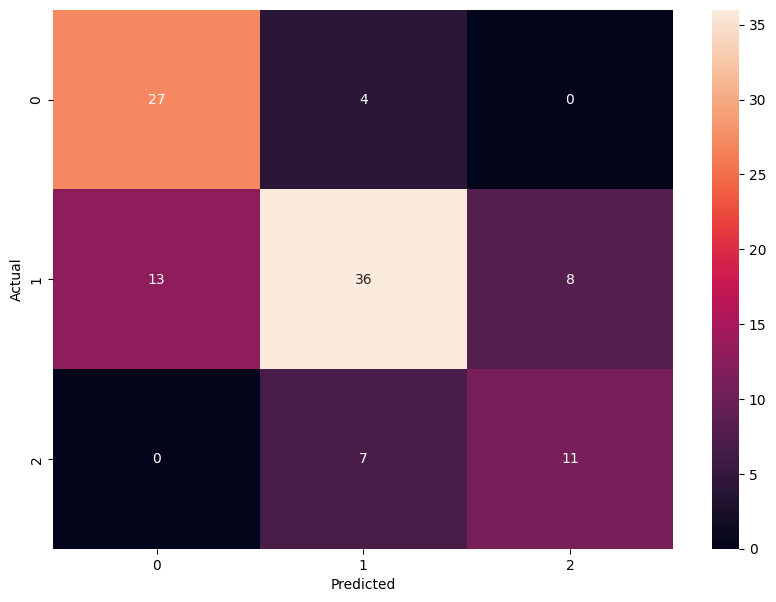

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 평가를 위한 설정
model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/model/model_v6/YCbCr_resnet50_0.0001_3_3_pigmentation_classification_model_v2.pth'

val_dataset = SkinDataset(csv_file="/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/res/annotation.csv",
                          image_folder='/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_r_images_val',
                          transform=transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 모델 로드 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_save_path)
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # val_loader로 변경
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 그리기
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

데이터 증강, 학습률 조정

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import copy
import pandas as pd
import numpy as np
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.models import ResNet50_Weights

# 데이터셋 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, csv_file=None, image_folder=None, image_paths=None, labels=None, transform=None):
        if csv_file is not None and image_folder is not None:
            # CSV 파일 로드 및 레이블 설정
            self.image_paths = []
            self.labels = []
            self.transform = transform

            df = pd.read_csv(csv_file)

            for image_file in os.listdir(image_folder):
                if image_file.endswith('.jpg'):
                    image_path = os.path.join(image_folder, image_file)
                    image_id = image_file.split('_')[0]
                    label_data = df[df['ID'] == int(image_id)]['r_cheek_pigmentation_3'].values
                    if len(label_data) > 0:
                        label = label_data[0]
                        self.image_paths.append(image_path)
                        self.labels.append(label)

            # 넘파이 배열로 변경
            self.image_paths = np.array(self.image_paths)
            self.labels = np.array(self.labels)
        elif image_paths is not None and labels is not None:
            self.image_paths = np.array(image_paths)
            self.labels = np.array(labels)
            self.transform = transform
        else:
            raise ValueError("Either (csv_file and image_folder) or (image_paths and labels) must be provided")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('YCbCr')  # YCbCr 색상 공간으로 변환
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


# 데이터셋 준비
csv_file = "/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/res/annotation.csv"
image_folder = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_r_images_train'

# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# 전체 데이터셋 생성
full_dataset = SkinDataset(csv_file=csv_file, image_folder=image_folder, transform=transform)

# 데이터 분할
image_paths = full_dataset.image_paths
labels = full_dataset.labels
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.1, random_state=3)

# 데이터셋 생성
train_dataset = SkinDataset(image_paths=train_image_paths, labels=train_labels, transform=transform)
val_dataset = SkinDataset(image_paths=val_image_paths, labels=val_labels, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=3)

# 모델 정의
class ResNetforClassification(nn.Module):
    def __init__(self, num_classes):
        super(ResNetforClassification, self).__init__()
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.dropout = nn.Dropout(p=0.5)  # 50% 드롭아웃
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            self.dropout,
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# `device` 변수를 여기에 선언
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 가중치 정의
class_weights = torch.tensor([2.0, 1.0, 2.5], dtype=torch.float32).to(device)

num_classes = 3  # 색소침착 등급이 3개
model = ResNetforClassification(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 추가
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)



# 조기 종료 클래스
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 모델 학습 및 검증
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=5):
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        corrects = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)
                val_total += labels.size(0)

        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model, model_save_path)

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model

model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/model/model_v6/YCbCr_resnet50_0.0001_3_3_pigmentation_classification_model_v2.pth'

model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=10)

Epoch [1/50], Train Loss: 1.0417, Train Accuracy: 0.4844, Val Loss: 1.5731, Val Accuracy: 0.6512
Epoch [2/50], Train Loss: 0.9921, Train Accuracy: 0.4922, Val Loss: 1.0396, Val Accuracy: 0.3488
Epoch [3/50], Train Loss: 0.8888, Train Accuracy: 0.5182, Val Loss: 0.8963, Val Accuracy: 0.5465
Epoch [4/50], Train Loss: 0.8714, Train Accuracy: 0.5740, Val Loss: 0.8510, Val Accuracy: 0.4535
Epoch [5/50], Train Loss: 0.8679, Train Accuracy: 0.5442, Val Loss: 0.6827, Val Accuracy: 0.5930
Epoch [6/50], Train Loss: 0.8313, Train Accuracy: 0.5273, Val Loss: 0.6947, Val Accuracy: 0.5698
EarlyStopping counter: 1 out of 10
Epoch [7/50], Train Loss: 0.8741, Train Accuracy: 0.5273, Val Loss: 0.7351, Val Accuracy: 0.5581
EarlyStopping counter: 2 out of 10
Epoch [8/50], Train Loss: 0.8372, Train Accuracy: 0.5221, Val Loss: 0.7039, Val Accuracy: 0.6163
EarlyStopping counter: 3 out of 10
Epoch [9/50], Train Loss: 0.8115, Train Accuracy: 0.6026, Val Loss: 0.7850, Val Accuracy: 0.5698
EarlyStopping counter:

Accuracy: 0.5943
Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.81      0.67        31
           1       0.69      0.47      0.56        57
           2       0.48      0.61      0.54        18

    accuracy                           0.59       106
   macro avg       0.58      0.63      0.59       106
weighted avg       0.62      0.59      0.59       106



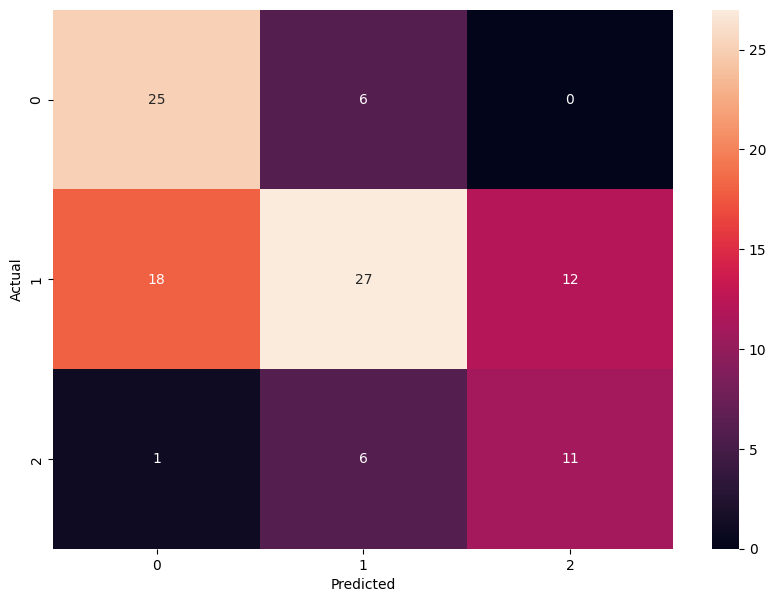

In [32]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 평가를 위한 설정
model_save_path = '/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/model/model_v6/YCbCr_resnet50_0.0001_3_3_pigmentation_classification_model_v2.pth'

val_dataset = SkinDataset(csv_file="/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet_v2/res/annotation.csv",
                          image_folder='/content/drive/MyDrive/Final_project_2조/02_2. 전처리 및 EDA_이미지/지우님/ResNet/res/cheek_r_images_val',
                          transform=transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 모델 로드 및 평가
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(model_save_path)
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:  # val_loader로 변경
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 평가 지표 계산
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

# 혼동 행렬 그리기
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

lr-finder

In [ ]:
# ! pip install fastai